In [3]:
import pandas as pd
import numpy as np

## orders

In [6]:
orders=pd.read_csv("./data/olist_orders_dataset.csv")
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
orders["order_delivered_customer_date"].value_counts(dropna=False)

order_delivered_customer_date
NaN                    2965
2018-07-24 21:36:42       3
2018-05-08 23:38:46       3
2018-05-14 20:02:44       3
2017-12-02 00:26:45       3
                       ... 
2018-07-12 17:48:45       1
2018-05-18 18:24:36       1
2018-01-17 13:29:13       1
2018-06-29 11:21:34       1
2018-03-16 13:08:30       1
Name: count, Length: 95665, dtype: int64

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


- 승인 안 된 주문 → order_approved_at NaN

- 배송 시작 안 된 주문 → order_delivered_carrier_date NaN

- 배송 완료 안 된 주문 (취소/미배송) → order_delivered_customer_date NaN

- 예상 배송일은 항상 있음 → 비교 기준 역할

In [13]:
# 1) 문자열 → datetime (실패값은 NaT로)
dt_cols = [
    'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for c in dt_cols:
    orders[c] = pd.to_datetime(orders[c], errors='coerce')

# object였던 배송 관련 칼럼도 여기서 정리됨


- dt_cols
    - atetime으로 바꿔야 할 컬럼 이름들의 모음 리스트

In [16]:
is_delivered = orders['order_status'].eq('delivered')
is_estimated_ok = orders['order_estimated_delivery_date'].notna()


In [18]:
# 날짜/시간 파생
orders['purchase_date']      = orders['order_purchase_timestamp'].dt.date
orders['purchase_year']      = orders['order_purchase_timestamp'].dt.year
orders['purchase_month']     = orders['order_purchase_timestamp'].dt.month
orders['purchase_dayofweek'] = orders['order_purchase_timestamp'].dt.dayofweek
orders['purchase_hour']      = orders['order_purchase_timestamp'].dt.hour

# 배송일수(배송 완료 주문만)
orders['delivery_days'] = pd.NA
mask = is_delivered & orders['order_delivered_customer_date'].notna()
orders.loc[mask, 'delivery_days'] = (
    orders.loc[mask, 'order_delivered_customer_date'] - 
    orders.loc[mask, 'order_purchase_timestamp']
).dt.total_seconds() / 86400

# 지연일수(음수는 0으로 클리핑)
import numpy as np

# 지연일 차이(실제 - 예상)
diff_days = (
    orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']
).dt.total_seconds() / 86400

# 배송완료 + 실제배송일 + 예상배송일이 있는 행만 계산
mask2 = (
    is_delivered
    & orders['order_delivered_customer_date'].notna()
    & orders['order_estimated_delivery_date'].notna()
)

# 지연일수 계산(아니면 NaN)
orders['delay_days'] = np.where(mask2, diff_days, np.nan)

# 음수(조기배송)는 0으로 클리핑
orders['delay_days'] = np.clip(orders['delay_days'], 0, None)

# 선택: 이진 플래그도 함께 생성하면 후속 분석 편함
orders['is_delayed'] = (orders['delay_days'] > 0).astype(int)


### orders EDA

In [21]:
# 기본 구조
orders.shape

(99441, 16)

In [23]:
# 전체 기간 (purchase_timestamp 최소~최대)

orders['order_status'].value_counts(normalize=True)

order_status
delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: proportion, dtype: float64

In [25]:
# 주문 상태(order_status) 분포
orders['order_purchase_timestamp'].min(), orders['order_purchase_timestamp'].max()

(Timestamp('2016-09-04 21:15:19'), Timestamp('2018-10-17 17:30:18'))

<Axes: xlabel='purchase_month'>

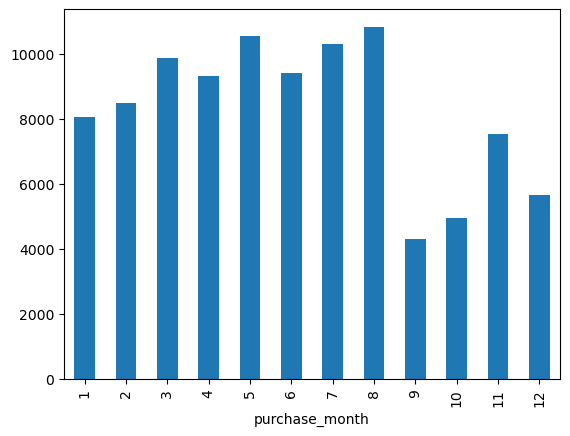

In [27]:
# 날짜, 시간 분포
# 월별 주문 건수 추이(라인 차트)
orders['purchase_month'].value_counts().sort_index().plot(kind='bar')


- 1~8월까지 안정적으로 높은 주문 건수
    - 특정 세일 이벤트와 연관 있을 수도
- 9월~12월까지 낮은 수준
    - 계절성의 문제라기 보다 후반부 데이터가 완전히 다 수집되지 않은 문제일수도


<Axes: xlabel='purchase_dayofweek'>

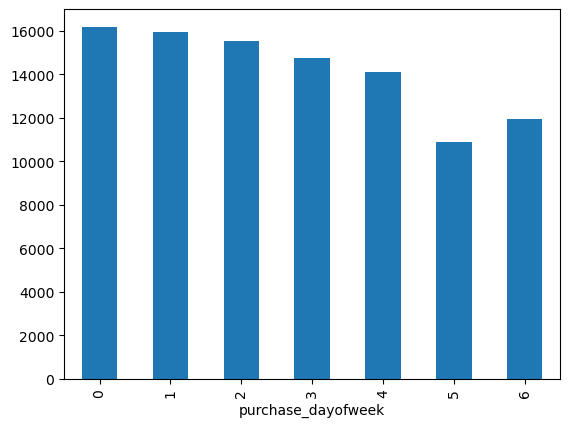

In [29]:
# 요일별 주문 건수 패턴
orders['purchase_dayofweek'].value_counts().sort_index().plot(kind='bar')


- 0= 월요일, 6= 일요일
    - 월(0)~수(2): 주문 건수 가장 많음 (16,000건 이상)
    - 목(3), 금(4): 소폭 감소 (15,000 → 14,000건 수준)
    - 토(5): 최저 (11,000건 수준)
    - 일(6): 다소 회복 (12,000건 정도)

- 해석:

    - 주중(특히 월~수)에 집중 → 소비자들이 업무일 초반에 온라인 구매를 처리하는 경향.
    - 주말(토)은 뚝 떨어지고, 일요일에 다시 약간 회복 → 아마도 평일 배송 시작을 고려해 일요일 저녁 온라인 쇼핑을 하는 소비자가 일정수 있음.

- 실무적 인사이트:

    - 광고/프로모션 타이밍을 월~수 집중하면 효과적일 수 있음.

<Axes: xlabel='purchase_hour'>

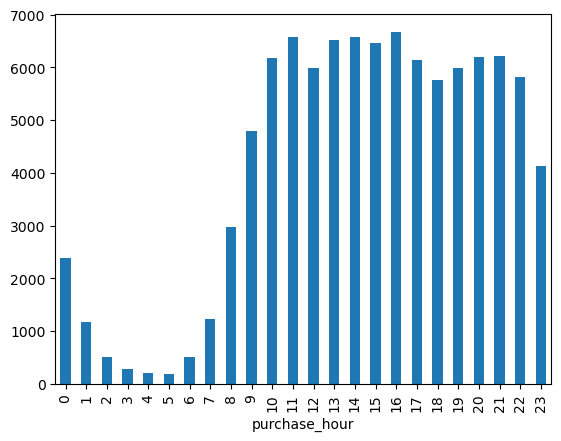

In [31]:
# 시간대별 주문 건수 분포
orders['purchase_hour'].value_counts().sort_index().plot(kind='bar')


- 새벽(1~6시): 주문 건수 거의 없음
- 오전 9시부터 급격히 증가 → 10시16시 사이가 피크 (6,0007,000건)
- 저녁(18~22시): 여전히 활발, 하지만 낮보다는 살짝 줄어듦
- 23시~0시: 감소

- 해석:
    - 주문 피크는 업무시간(10~16시) → 직장/회사 환경에서 PC로 쇼핑하는 패턴이 반영된 듯.
    - 저녁에도 꾸준히 구매가 이뤄지지만, 낮 피크만큼은 아님.

- 실무적 인사이트:
    - 배송/서버 부하 관리 → 낮 시간대에 집중 필요.

- 마케팅 관점에서는 **점심시간 직전(11-12시), 오후 초반(13-15시)**이 효과적인 타겟 시간대일 수 있음.

In [36]:
# 배송 관련 기초
# 배송 완료율 비율
(orders['order_status']=='delivered').mean()


0.9702034372140264

In [38]:
# delivery days 분포
orders['delivery_days'].describe()


count     96470.000000
unique    93803.000000
top          13.145729
freq          3.000000
Name: delivery_days, dtype: float64

In [40]:
# delay_days 분포
orders['delay_days'].describe()


count    96470.000000
mean         0.774875
std          4.753087
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        188.975081
Name: delay_days, dtype: float64

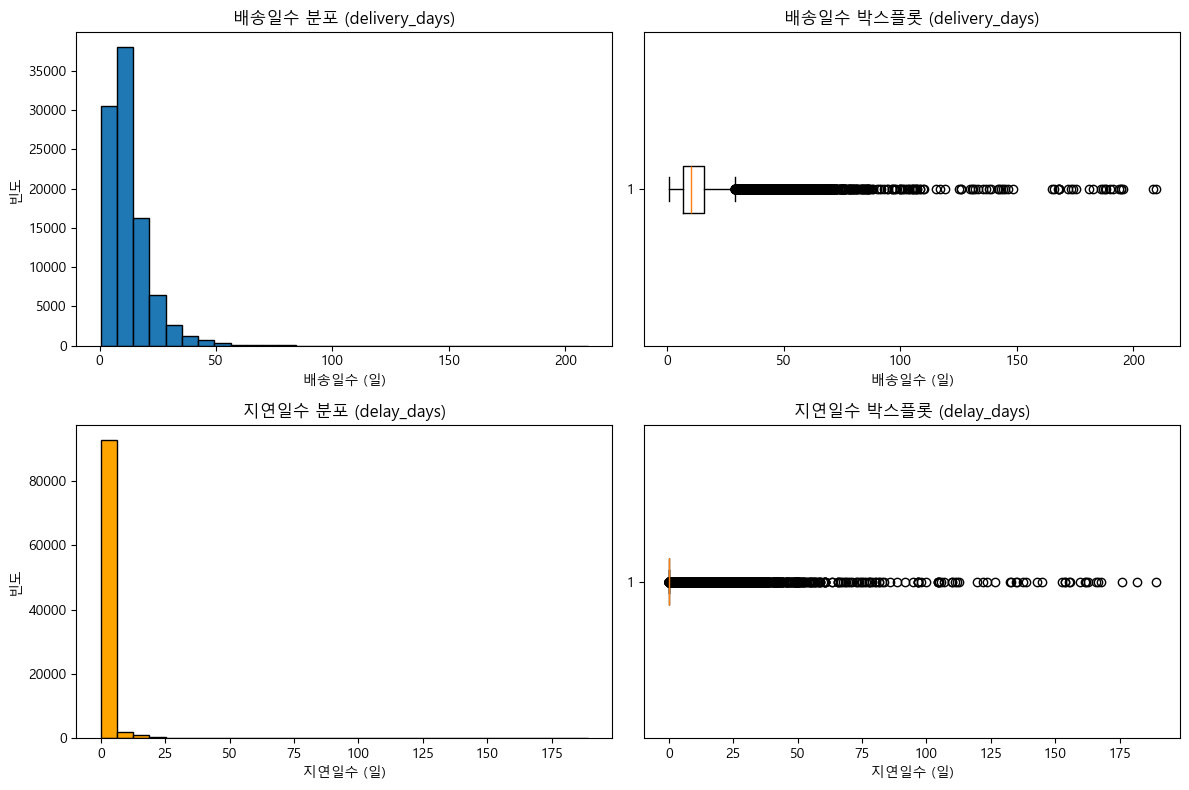

In [42]:
# 시각화
import matplotlib.pyplot as plt

# 한글 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우
# plt.rcParams['font.family'] = 'AppleGothic'  # 맥
# plt.rcParams['axes.unicode_minus'] = False   # 마이너스 깨짐 방지

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1) delivery_days 히스토그램
axes[0,0].hist(orders['delivery_days'].dropna(), bins=30, edgecolor='black')
axes[0,0].set_title("배송일수 분포 (delivery_days)")
axes[0,0].set_xlabel("배송일수 (일)")
axes[0,0].set_ylabel("빈도")

# 2) delivery_days 박스플롯
axes[0,1].boxplot(orders['delivery_days'].dropna(), vert=False)
axes[0,1].set_title("배송일수 박스플롯 (delivery_days)")
axes[0,1].set_xlabel("배송일수 (일)")

# 3) delay_days 히스토그램
axes[1,0].hist(orders['delay_days'].dropna(), bins=30, edgecolor='black', color='orange')
axes[1,0].set_title("지연일수 분포 (delay_days)")
axes[1,0].set_xlabel("지연일수 (일)")
axes[1,0].set_ylabel("빈도")

# 4) delay_days 박스플롯
axes[1,1].boxplot(orders['delay_days'].dropna(), vert=False, patch_artist=True,
                  boxprops=dict(facecolor="orange"))
axes[1,1].set_title("지연일수 박스플롯 (delay_days)")
axes[1,1].set_xlabel("지연일수 (일)")

plt.tight_layout()
plt.show()


#### 배송일수 분포 (delivery_days)

- 히스토그램
    - 대부분의 주문이 2-20일 사이에 배송됨을 보여줘. 특히 5-10일에 가장 많이 몰려 있어.
    - 하지만 극단적으로 50일 이상 걸리는 경우도 있고, 최대 200일 이상 걸린 이상치도 존재해.

- 박스플롯

    - 중앙값이 약 10일 근처이고, IQR(사분위 범위)도 좁지만, 오른쪽 꼬리가 굉장히 길게 늘어나 있음 → 배송 지연으로 인한 롱테일 분포.
    - 즉, “대부분 정상적으로 1~2주 내 도착하지만 일부는 매우 늦어지는 케이스가 있다”는 패턴.

#### 지연일수 분포 (delay_days)

- 히스토그램
    - 대부분이 0일(지연 없음) 근처에 몰려 있음. 즉, 예측된 배송일보다 늦게 도착하지 않은 경우가 대다수.
    - 하지만 소수의 주문은 10일 이상 지연되었고, 심지어 100일 이상 지연된 경우도 있어 → 이는 데이터 오류거나, 실제로 취소/분쟁이 늦게 처리된 건일 수 있어.

- 박스플롯

    - 중앙값은 0, 대부분이 0~2일 사이에 있지만, 극단적인 아웃라이어가 매우 많아.
    - → “배송 시스템은 대체로 정상 동작하지만, 소수의 케이스가 고객 경험을 크게 해칠 수 있다”는 시사점.

#### 종합 해석

- 핵심 패턴
    - 정상 배송은 대체로 5~15일 내에 완료된다.
    - 대부분은 지연되지 않지만, 일부 극단적 지연 주문이 전체 서비스 신뢰도에 큰 악영향을 줄 수 있음.
    - 따라서 단순 평균보다는 **지연율(0일 초과 비율)**이나 95%/99% 분위수 지표를 보는 것이 더 적절하다.

- 비즈니스 인사이트

    - SLA(Service Level Agreement)를 “95%의 주문은 15일 내 도착”처럼 정의하면, 실제 성과 측정을 잘 할 수 있음.
    - 극단적 이상치(예: 100일 이상 지연)는 별도로 분리 분석 → 시스템 오류인지, 환불/재배송인지 원인 파악 필요.

## items

In [47]:
items=pd.read_csv("./data/olist_order_items_dataset.csv")
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


## 주문 단위로 매출 계산

In [50]:
import pandas as pd
import numpy as np

# 0-1) datetime 변환 (안전하게)
dt_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for c in dt_cols:
    orders[c] = pd.to_datetime(orders[c], errors='coerce')

# 0-2) 시간 파생
orders['purchase_year']      = orders['order_purchase_timestamp'].dt.year
orders['purchase_month']     = orders['order_purchase_timestamp'].dt.month
orders['purchase_dayofweek'] = orders['order_purchase_timestamp'].dt.dayofweek  # 0=월
orders['purchase_hour']      = orders['order_purchase_timestamp'].dt.hour

# 0-3) 배송일수(실제 소요일)
mask_delivery = (
    orders['order_status'].eq('delivered') &
    orders['order_delivered_customer_date'].notna()
)
orders['delivery_days'] = np.where(
    mask_delivery,
    (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']
    ).dt.total_seconds() / 86400,
    np.nan
)
# 극단치 방어(예: 0~60일 범위 안으로)
orders['delivery_days'] = np.clip(orders['delivery_days'], 0, 60)

# 0-4) 지연일수(예상 대비 초과분만, 음수=0 처리)
mask_delay = (
    orders['order_status'].eq('delivered') &
    orders['order_delivered_customer_date'].notna() &
    orders['order_estimated_delivery_date'].notna()
)
diff_days = (
    orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']
).dt.total_seconds() / 86400

orders['delay_days'] = np.where(mask_delay, diff_days, np.nan)
orders['delay_days'] = np.clip(orders['delay_days'], 0, None)  # 음수 → 0


In [52]:
# 1-1) order_items 로드 (이미 DF가 있다면 이 블록 생략)

# 1-2) 주문별 매출 집계
rev_per_order = (
    items.assign(order_revenue = items['price'] + items['freight_value'])
         .groupby('order_id', as_index=False)
         .agg(
             gmv=('price', 'sum'),
             shipping_rev=('freight_value', 'sum'),
             order_revenue=('order_revenue', 'sum'),
             items_cnt=('order_id', 'size')
         )
)


In [54]:
# 2-1) orders × rev_per_order 병합
orders_master = orders.merge(rev_per_order, on='order_id', how='left')

# 2-2) 실매출 기준 필터 (필요 시)
base = orders_master[
    (orders_master['order_status'] == 'delivered') &
    (orders_master['order_approved_at'].notna())
].copy()

# 2-3) 분석에 바로 쓰기 좋은 핵심 컬럼만 정리(원하면 확장)
cols = [
    'order_id', 'customer_id',
    'order_status',
    'purchase_year','purchase_month','purchase_dayofweek','purchase_hour',
    'delivery_days','delay_days',
    'gmv','shipping_rev','order_revenue','items_cnt'
]
base = base[cols]

# 2-4) 지연 여부 플래그(후속 분석 편의)
base['is_delayed'] = (base['delay_days'] > 0).astype(int)


In [56]:

# 행/열 수
base.shape

# 매출 통계
base['order_revenue'].describe()

# 월별 매출 합계
base.groupby('purchase_month')['order_revenue'].sum().sort_index()

# 지연 유무별 객단가 비교
base.groupby('is_delayed')['order_revenue'].agg(['mean','median','count'])


,mean,median,count
is_delayed,,,
0,158.692594,104.620,88638
1,172.709553,112.235,7826


In [58]:
# 판매자 매출(선택)
seller_sales = (
    items.assign(revenue = items['price'] + items['freight_value'])
         .groupby('seller_id', as_index=False)
         .agg(
             gmv=('price','sum'),
             shipping_rev=('freight_value','sum'),
             revenue=('revenue','sum'),
             orders=('order_id','nunique'),
             items_cnt=('order_id','size')
         )
)


In [60]:
base

,order_id,customer_id,order_status,purchase_year,purchase_month,purchase_dayofweek,purchase_hour,delivery_days,delay_days,gmv,shipping_rev,order_revenue,items_cnt,is_delayed
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017,10,0,10,8.436574,0.0,29.99,8.72,38.71,1.0,0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018,7,1,20,13.782037,0.0,118.70,22.76,141.46,1.0,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018,8,2,8,9.394213,0.0,159.90,19.22,179.12,1.0,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017,11,5,19,13.208750,0.0,45.00,27.20,72.20,1.0,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018,2,1,21,2.873877,0.0,19.90,8.72,28.62,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017,3,3,9,8.218009,0.0,72.00,13.08,85.08,1.0,0
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018,2,1,12,22.193727,0.0,174.90,20.10,195.00,1.0,0
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017,8,6,14,24.859421,0.0,205.99,65.02,271.01,1.0,0
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018,1,0,21,17.086424,0.0,359.98,81.18,441.16,2.0,0


In [62]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96464 entries, 0 to 99440
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            96464 non-null  object 
 1   customer_id         96464 non-null  object 
 2   order_status        96464 non-null  object 
 3   purchase_year       96464 non-null  int32  
 4   purchase_month      96464 non-null  int32  
 5   purchase_dayofweek  96464 non-null  int32  
 6   purchase_hour       96464 non-null  int32  
 7   delivery_days       96456 non-null  float64
 8   delay_days          96456 non-null  float64
 9   gmv                 96464 non-null  float64
 10  shipping_rev        96464 non-null  float64
 11  order_revenue       96464 non-null  float64
 12  items_cnt           96464 non-null  float64
 13  is_delayed          96464 non-null  int32  
dtypes: float64(6), int32(5), object(3)
memory usage: 9.2+ MB


| 컬럼명                     | 타입             | 정의 / 계산 방식                                       | 해석 및 활용 포인트                                                |
| ----------------------- | -------------- | ------------------------------------------------ | ---------------------------------------------------------- |
| **order\_id**           | str            | 주문(결제 단위) 식별자                                    | 주문별 매출 집계 기준. 다른 테이블(`items`, `payments`, `reviews`)과 조인 키 |
| **customer\_id**        | str            | 고객 식별자                                           | 한 고객은 여러 주문 가능. 고객당 매출, 재구매율 분석 가능                         |
| **order\_status**       | categorical    | 주문 상태 (`delivered`, `canceled` 등)                | 보통 `delivered`만 분석(실매출). 취소율/미배송율 KPI에 활용                  |
| **purchase\_year**      | int            | 주문 발생 연도                                         | 연간 매출 트렌드, 성장 추세                                           |
| **purchase\_month**     | int            | 주문 발생 월                                          | 계절성, 월별 매출 비교                                              |
| **purchase\_dayofweek** | int (0=월\~6=일) | 주문 발생 요일                                         | 요일별 매출 패턴, 마케팅 타이밍                                         |
| **purchase\_hour**      | int (0\~23)    | 주문 발생 시간                                         | 시간대별 매출 집중도, 프로모션/운영 전략                                    |
| **delivery\_days**      | float          | 배송일수 = `delivered_date - purchase_date`          | 리드타임 성과 측정, SLA(서비스 수준) 분석, 상위 분위수(95%) 확인 필요              |
| **delay\_days**         | float          | 지연일수 = `max(0, delivered_date - estimated_date)` | 배송 지연 분석. 0은 정상 배송, NaN은 계산 불가(예상일 없음 등)                   |
| **gmv**                 | float          | 상품 매출 합계 (`price` 합)                             | 상품 자체 매출(배송비 제외). GMV(Gross Merchandise Value)             |
| **shipping\_rev**       | float          | 배송비 합계 (`freight_value` 합)                       | 배송비 매출. 매출 구조 분석 시 중요                                      |
| **order\_revenue**      | float          | 총 매출 = `gmv + shipping_rev`                      | 실제 주문 단위 매출 금액 (분석의 핵심 지표)                                 |
| **items\_cnt**          | int            | 주문 내 상품 개수 (`order_item_id` 개수)                  | 장바구니 크기, 교차판매 효과                                           |
| **is\_delayed**         | int (0/1)      | 배송 지연 여부 (`delay_days > 0`)                      | 지연 여부별 매출 차이 분석, KPI로 활용                                   |


In [65]:
base.describe()

,purchase_year,purchase_month,purchase_dayofweek,purchase_hour,delivery_days,delay_days,gmv,shipping_rev,order_revenue,items_cnt,is_delayed
count,96464.000000,96464.000000,96464.000000,96464.000000,96456.000000,96456.000000,96464.000000,96464.000000,96464.000000,96464.000000,96464.000000
mean,2017.544410,6.031722,2.756313,14.773263,12.473237,0.774988,137.044158,22.785614,159.829772,1.142208,0.081129
std,0.503553,3.228231,1.967055,5.328427,8.779426,4.753423,209.056826,21.560553,218.806449,0.538833,0.273034
min,2016.000000,1.000000,0.000000,0.000000,0.533414,0.000000,0.850000,0.000000,9.590000,1.000000,0.000000
25%,2017.000000,3.000000,1.000000,11.000000,6.765550,0.000000,45.900000,13.850000,61.850000,1.000000,0.000000
50%,2018.000000,6.000000,3.000000,15.000000,10.216267,0.000000,86.590000,17.170000,105.280000,1.000000,0.000000
75%,2018.000000,8.000000,4.000000,19.000000,15.720229,0.000000,149.900000,24.012500,176.302500,1.000000,0.000000
max,2018.000000,12.000000,6.000000,23.000000,60.000000,188.975081,13440.000000,1794.960000,13664.080000,21.000000,1.000000


#### 배송 관련
- delivery_days: 평균 12.47일, 중앙값 10.2일 → 일반적으로 10일 전후 걸림.
    - 최소 0.5일 (익일·당일배송?)
    - 최대 60일 → 이상치 존재 (매우 느린 배송)

- delay_days: 평균 0.77일, 중앙값 0.0 → 대부분 지연 없음.

    - 최대 189일 지연 → 일부 극단치 존재.
    - 박스플롯에서 outlier 제거 후 분석 필요.

#### 매출 관련

- gmv (상품 매출)
    - 평균 137.0, 중앙값 86.6
    - 최대 13,440 → 고가 상품 또는 다량 구매 주문 있음.
    - 분포가 long-tail (상위 few 주문이 매출 견인) 패턴임을 암시.

- shipping_rev (배송비 매출)

    - 평균 22.8, 중앙값 17.1
    - 최대 1,794.96 → 무게·거리 영향. 배송비 비중 분석 필요.

- order_revenue (총 매출 = gmv+배송비)

    - 평균 159.8, 중앙값 105.3
    - 최대 13,664 → 매출도 long-tail.

In [70]:
# long tail 인지 확인해보는 시각화


# 분석 대상 컬럼 선택 (원하면 'order_revenue'도 추가 가능)
targets = {
    "GMV (price sum)": "gmv",
    "Shipping Revenue (freight sum)": "shipping_rev",
    "Order Revenue (gmv+shipping)": "order_revenue",  # 선택
}

# 극단치 클리핑 범위(옵션) — 필요 시 조정
CLIP_MAX = {
    "gmv":            base["gmv"].quantile(0.999),            # 상위 0.1% 컷
    "shipping_rev":   base["shipping_rev"].quantile(0.999),
    "order_revenue":  base["order_revenue"].quantile(0.999),
}

def get_series(df, col, clip_max=None):
    s = df[col].dropna().astype(float)
    if clip_max is not None:
        s = s.clip(lower=0, upper=clip_max)
    # 0인 값이 많으면 log축/CCDF에서 문제될 수 있어 아주 작은 epsilon 추가(옵션)
    s = s + 1e-8
    return s


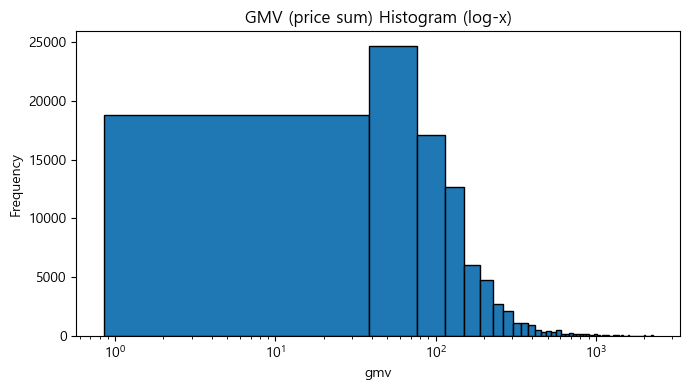

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

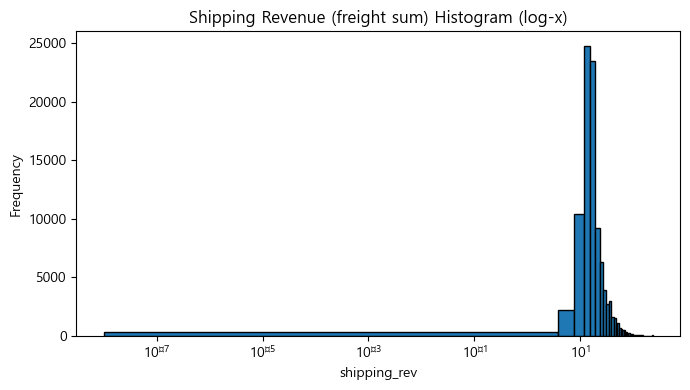

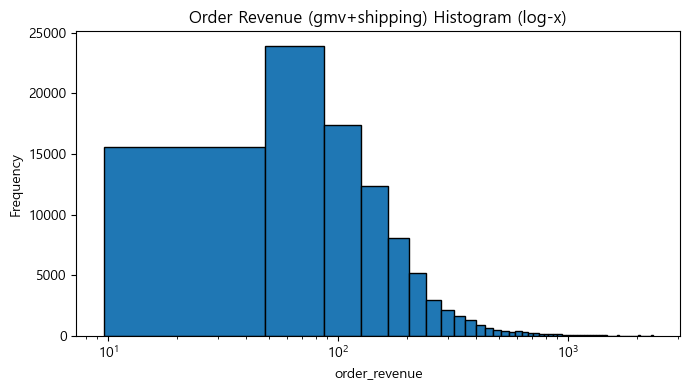

In [72]:
for title, col in targets.items():
    s = get_series(base, col, CLIP_MAX.get(col))
    plt.figure(figsize=(7,4))
    plt.hist(s, bins=60, edgecolor='black')
    plt.xscale('log')  # 값 분포가 넓을 때 필수
    plt.title(f"{title} Histogram (log-x)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


1. GMV (상품 매출액) 분포
- 로그 스케일에서 보니, **대부분의 주문이 낮은 금액대(10~100 단위)**에 집중되어 있고, 일부 극단적으로 높은 매출(1000 이상)을 보이는 주문이 있음.
- 전형적인 Long-tail 분포
- 즉, 소수의 주문이 전체 매출의 큰 비중을 차지한다는 뜻. 
- 매출 분석에서는 이런 상위 매출 기여 주문(또는 고객)을 따로 뽑아보는 게 중요함 → Pareto(80:20) 법칙 적용 가능.

2. Shipping Revenue (배송비 매출) 분포

- 배송비는 대부분 10~30 정도의 작은 값에 몰려 있고, 분포도 좁음.
- 따라서 배송비 매출은 GMV처럼 Long-tail 특성이 거의 없음.
- 여기서 볼 수 있는 건, 배송비가 매출에서 차지하는 비중은 상대적으로 작으며, 분석 포인트는 "배송비 자체"가 아니라 배송비와 배송일수/지연의 상관관계를 보는 게 의미 있음. (예: 배송비가 높은 경우 배송일이 더 짧아지는가? → 고객 만족도 및 매출 증대 연결 가능)

3. Order Revenue (총 매출 = 상품 + 배송비) 분포
- GMV와 비슷한 분포 형태를 가짐 (왜냐하면 배송비는 상대적으로 작기 때문).
- 즉, 총 매출(order_revenue)도 역시 Long-tail 구조를 보임.
- 이걸 통해 매출 기여도 상위 그룹을 따로 나눠 분석하는 것이 필요함을 알 수 있음.

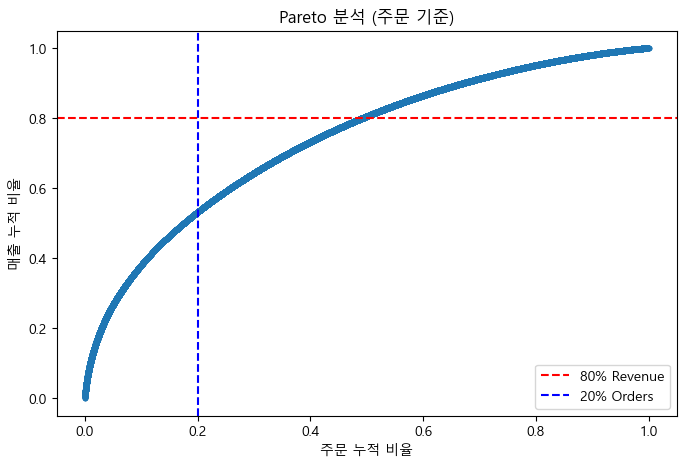

In [74]:


# Pareto 분석용 데이터: 주문별 매출
pareto = base[['order_id', 'order_revenue']].groupby('order_id').sum().reset_index()

# 매출 기준 내림차순 정렬
pareto = pareto.sort_values(by='order_revenue', ascending=False).reset_index(drop=True)

# 누적 매출 비율 계산
pareto['cum_revenue'] = pareto['order_revenue'].cumsum()
pareto['cum_revenue_pct'] = pareto['cum_revenue'] / pareto['order_revenue'].sum()

# 누적 주문 비율 계산
pareto['cum_orders_pct'] = np.arange(1, len(pareto)+1) / len(pareto)

# 시각화
plt.figure(figsize=(8,5))
plt.plot(pareto['cum_orders_pct'], pareto['cum_revenue_pct'], marker='.')
plt.axhline(0.8, color='red', linestyle='--', label='80% Revenue')
plt.axvline(0.2, color='blue', linestyle='--', label='20% Orders')
plt.xlabel('주문 누적 비율')
plt.ylabel('매출 누적 비율')
plt.title('Pareto 분석 (주문 기준)')
plt.legend()
plt.show()


- 상위 20%의 주문이 전체 매출의 50% 이상을 차지함
- 약 상위 40-45%가 전체 매출의 80%를 차지함

- 이 그래프는 주문 매출이 고르게 분포되지 않고, 일부 주문이 대부분의 매출을 차지한다는 걸 보여줌.
- 나머지 주문들은 매출 기여도가 작고, 길게 꼬리를 형성 → 롱테일 구조.
    - 상위 매출 주문군에 대해서 배송이 빨라지면 매출 유지·증가 효과가 클 수 있음.

C:\Users\charl\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


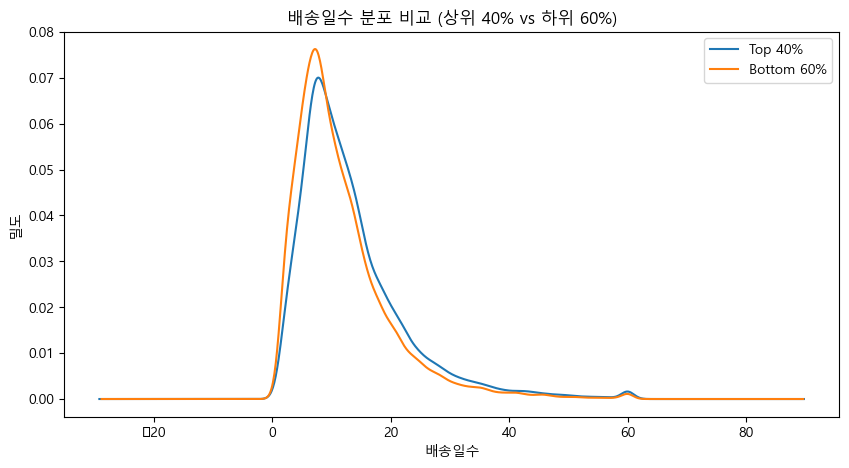

              count       mean       std       min       25%        50%  \
group                                                                     
Bottom 60%  48993.0  11.647781  8.338919  0.781366  6.131470   9.485509   
Top 40%     47463.0  13.325302  9.134243  0.533414  7.214277  11.052650   

                  75%   max  
group                        
Bottom 60%  14.748958  60.0  
Top 40%     16.748223  60.0  


In [77]:

# Pareto 기준: order_revenue 내림차순 정렬
base_sorted = base.sort_values('order_revenue', ascending=False).reset_index(drop=True)

# 누적 매출 비율 계산
base_sorted['cum_revenue_ratio'] = base_sorted['order_revenue'].cumsum() / base_sorted['order_revenue'].sum()

# 상위 40% vs 하위 60% 구분
base_sorted['group'] = (base_sorted['cum_revenue_ratio'] <= 0.8).map({True: 'Top 40%', False: 'Bottom 60%'})

# 배송일수 분포 비교
plt.figure(figsize=(10,5))
for g in ['Top 40%', 'Bottom 60%']:
    subset = base_sorted[base_sorted['group']==g]['delivery_days']
    subset.plot(kind='kde', label=g)  # 커널 밀도 함수로 분포 비교
    
plt.title("배송일수 분포 비교 (상위 40% vs 하위 60%)")
plt.xlabel("배송일수")
plt.ylabel("밀도")
plt.legend()
plt.show()

# 집단별 요약 통계
print(base_sorted.groupby('group')['delivery_days'].describe())


- 매출 상위 집단(40%)과 그 외 집단(60%)의 배송일수 차이는 크게 나지 않음
- 다만 상위 집단의 배송이 좀 더 걸리는 사실 발견
    - 왜 그런 것일까?
    - 고가 상품 or 특수 배송 상품?
    - 상품 카테고리, 지역 등과 함께 비교할 필요

### 배송 분석과 연결점
- 배송 일수에 영향을 줄 수 있는 요인들
    - 상품 카테고리
        - olist_products_dataset.csv 활용
    - 지역(배송지 / 판매자 위치)
        -  olist_customers_dataset.csv, olist_sellers_dataset.csv 활용

    - 판매자 특성
        -  olist_sellers_dataset.csv + join
    -  상품 특수성(치수/무게)
        - olist_products_dataset.csv에서 product_weight_g, product_length_cm, product_height_cm, product_width_cm

이걸 조인해서 배송일수의 결정 요인(상품/지역/판매자 특성)을 뽑아낼 수 있음

### 매출 추이 분석(월/요일/시간)

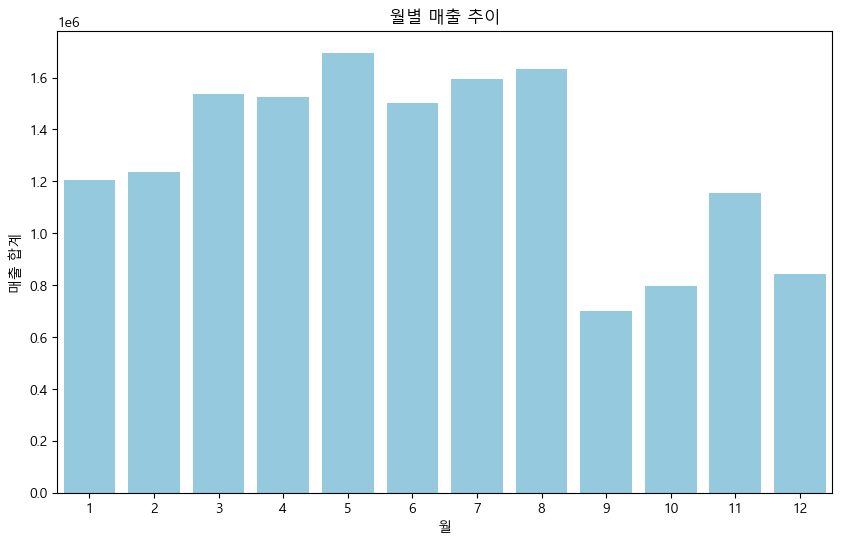

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 깨짐 방지 (colab 환경이라면)
plt.rc('font', family='Malgun Gothic')  # 윈도우
# plt.rc('font', family='AppleGothic')  # 맥
plt.rc('axes', unicode_minus=False)

# --------------------------
# 1. 월별 매출 추이
# --------------------------
monthly_revenue = base.groupby('purchase_month')['order_revenue'].sum()

plt.figure(figsize=(10,6))
sns.barplot(x=monthly_revenue.index, y=monthly_revenue.values, color="skyblue")
plt.title("월별 매출 추이")
plt.xlabel("월")
plt.ylabel("매출 합계")
plt.show()


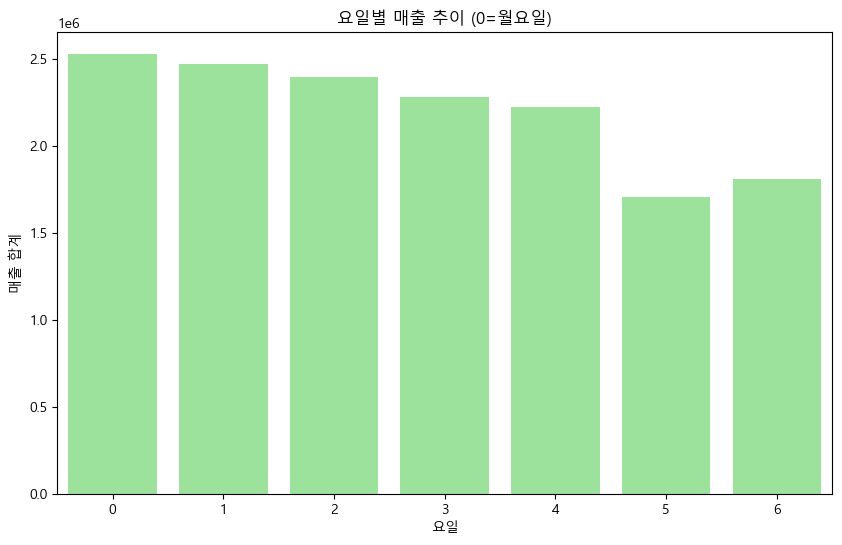

In [84]:

# --------------------------
# 2. 요일별 매출 추이
# --------------------------
weekday_revenue = base.groupby('purchase_dayofweek')['order_revenue'].sum()

plt.figure(figsize=(10,6))
sns.barplot(x=weekday_revenue.index, y=weekday_revenue.values, color="lightgreen")
plt.title("요일별 매출 추이 (0=월요일)")
plt.xlabel("요일")
plt.ylabel("매출 합계")
plt.show()



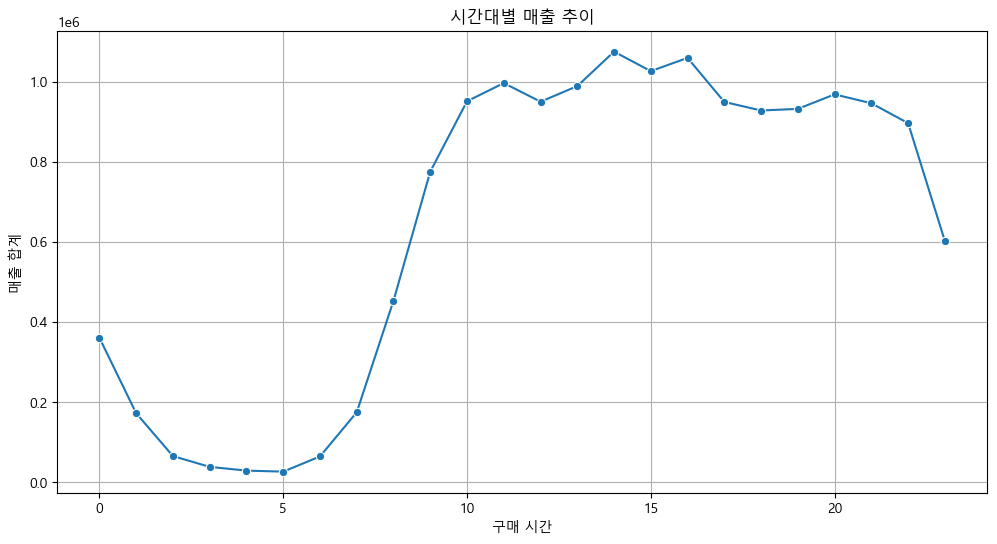

In [85]:
# --------------------------
# 3. 시간대별 매출 추이
# --------------------------
hourly_revenue = base.groupby('purchase_hour')['order_revenue'].sum()

plt.figure(figsize=(12,6))
sns.lineplot(x=hourly_revenue.index, y=hourly_revenue.values, marker="o")
plt.title("시간대별 매출 추이")
plt.xlabel("구매 시간")
plt.ylabel("매출 합계")
plt.grid(True)
plt.show()


### 배송 지연 여부별 객단가 추이

C:\Users\charl\AppData\Local\Temp\ipykernel_19176\545243797.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=aov_by_delay, x='is_delayed', y='order_revenue', palette='Set2')


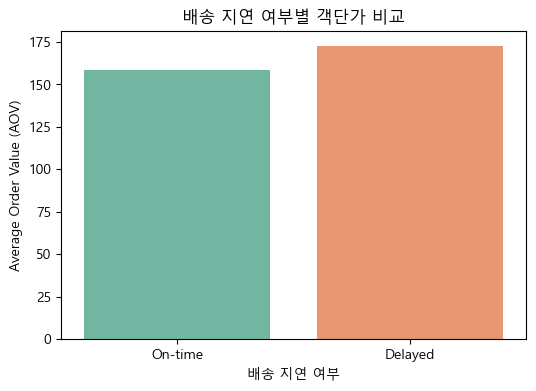

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# 배송 지연 여부별 객단가 계산
aov_by_delay = base.groupby('is_delayed')['order_revenue'].mean().reset_index()

# 시각화
plt.figure(figsize=(6,4))
sns.barplot(data=aov_by_delay, x='is_delayed', y='order_revenue', palette='Set2')

# 라벨/타이틀
plt.xticks([0,1], ['On-time', 'Delayed'])
plt.ylabel("Average Order Value (AOV)")
plt.xlabel("배송 지연 여부")
plt.title("배송 지연 여부별 객단가 비교")
plt.show()


- On-time(제시간 배송): 객단가 평균이 약 160 수준
- Delayed(지연 배송): 객단가 평균이 약 170 이상

    - 지연된 주문일수록 평균 객단가가 더 높게 나타났음.
    - 고가 상품 또는 특수한 배송 조건(해외 배송, 큰 부피, 특수 처리 등) 때문에 지연이 발생했다면? 

1. 상품 카테고리별로 나눠서 지연 여부 vs 객단가

2. 지역(거리)별로 배송일수 차이

3. 고가/저가 상품 구간별 지연 패턴

## 디벨롭

In [91]:
products=pd.read_csv("./data/olist_products_dataset.csv")
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [92]:
cat_tr=pd.read_csv("./data/product_category_name_translation.csv")
cat_tr.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [93]:
# cat_tr = 포르투갈 어를 영어로 번역해줌(번역 테이블임)
# 상품 + 번역 테이블 join하기

# 영어 카테고리로 매핑하기
products=products.merge(
    cat_tr[["product_category_name", "product_category_name_english"]],
    on="product_category_name",
    how="left"
)

products["category"] = products["product_category_name_english"].fillna(products["product_category_name"])
# 영어 번역 없는 행(nan)에 한해서 원래 포트루갈어 카테고리로 채워넣기

In [102]:
# items에 카테고리 붙이기
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [104]:
oi = items.merge(products[["product_id", "category"]], on = "product_id", how="left")

In [106]:
# 주문 단위 '대표 카테고리' 만들기 (두 기준 중 택1 또는 동시 비교)
# (A) 주문 내 '아이템 개수' 기준 대표 카테고리
cat_cnt = (oi.groupby(["order_id", "category"])["order_item_id"]
             .count()
             .rename("n_items_in_cat")
             .reset_index())
cat_rep_by_count = (cat_cnt.sort_values(["order_id","n_items_in_cat"], ascending=[True, False])
                           .drop_duplicates(subset=["order_id"])
                           .rename(columns={"category":"category_rep_count"}))

# (B) 주문 내 '금액 합계' 기준 대표 카테고리
cat_amt = (oi.groupby(["order_id", "category"])["price"]
             .sum()
             .rename("amount_in_cat")
             .reset_index())
cat_rep_by_amount = (cat_amt.sort_values(["order_id","amount_in_cat"], ascending=[True, False])
                            .drop_duplicates(subset=["order_id"])
                            .rename(columns={"category":"category_rep_amount"}))


- '주문 대표 카테고리'가 필요한 이유
    - 한 주문(order_id)에 여러 카테고리 상품이 섞여 있을 수 있음
    - 배송, 리뷰, 매출 분석을 '주문 라벨'로 할 때 카테고리 축을 붙이려면 주문별로 카테고리 하나를 대표화해야함
- 대표화의 두 가지 기준
    - 1. 아이템 개수 기준(count-based)
         - 주문 안에 가장 많이 담긴 카테고리를 대표로 선택
         - 장바구니의 주요 목적을 잘 반영
         - 소액 다건이 많은 카테고리에서 유용
         - ex) 식품3+가전1 -> 대표는 식품
      2. 금액 기준(amount-based)
         - 주문 안에서 금액 합계가 가장 큰 카테고리를 대표로 선택
         - 매출 관점에서 가장 비즈니스 임팩트가 큰 카테고리
         - ex) 식품3개(3만원)+가전1개(50만원) -> 대표는 가전

In [108]:
# orders에 대표 카테고리 붙이기


# 만약 아래 파생치가 없다면(이미 있으면 생략)
# for c in ["order_purchase_timestamp","order_estimated_delivery_date","order_delivered_customer_date"]:
#     if c in orders.columns:
#         orders[c] = pd.to_datetime(orders[c], errors="coerce")
# orders["delivery_days"]  = (orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]).dt.days
# orders["estimated_days"] = (orders["order_estimated_delivery_date"] - orders["order_purchase_timestamp"]).dt.days
# orders["delay_days"]     = orders["delivery_days"] - orders["estimated_days"]
# orders["is_delayed"]     = (orders["delay_days"] > 0).astype(int)

orders_cat = (orders
              .merge(cat_rep_by_count[["order_id","category_rep_count"]], on="order_id", how="left")
              .merge(cat_rep_by_amount[["order_id","category_rep_amount"]], on="order_id", how="left"))


#### 5) 카테고리별 지표 (대표 카테고리 기준)

In [112]:
# 카테고리별 핵심 지표(평균 배송일수, 지연율, AOV 등)

# 주문 총액
order_amount = (oi.groupby("order_id")["price"].sum()
                  .rename("order_amount").to_frame())
orders_cat = orders_cat.merge(order_amount, on="order_id", how="left")

# (A) '아이템 개수' 기준 대표 카테고리 지표
cat_metrics_count = (orders_cat.groupby("category_rep_count")
                     .agg(
                         n_orders=("order_id","nunique"),
                         avg_delivery_days=("delivery_days","mean"),
                         delay_rate=("is_delayed","mean"),
                         aov=("order_amount","mean")
                     )
                     .sort_values(["delay_rate","avg_delivery_days"], ascending=[False, False]))
cat_metrics_count["delay_rate"] = (cat_metrics_count["delay_rate"]*100).round(2)
cat_metrics_count = cat_metrics_count.round({"avg_delivery_days":2, "aov":2})

# (B) '금액 합계' 기준 대표 카테고리 지표
cat_metrics_amount = (orders_cat.groupby("category_rep_amount")
                      .agg(
                          n_orders=("order_id","nunique"),
                          avg_delivery_days=("delivery_days","mean"),
                          delay_rate=("is_delayed","mean"),
                          aov=("order_amount","mean")
                      )
                      .sort_values(["delay_rate","avg_delivery_days"], ascending=[False, False]))
cat_metrics_amount["delay_rate"] = (cat_metrics_amount["delay_rate"]*100).round(2)
cat_metrics_amount = cat_metrics_amount.round({"avg_delivery_days":2, "aov":2})

# 확인
display(cat_metrics_count.head(20))
display(cat_metrics_amount.head(20))


,n_orders,avg_delivery_days,delay_rate,aov
category_rep_count,,,,
home_comfort_2,23,14.56,17.39,36.06
furniture_mattress_and_upholstery,38,14.10,13.16,114.95
audio,350,13.47,12.86,149.36
fashion_underwear_beach,121,14.00,12.40,78.86
home_confort,351,13.40,10.83,153.75
books_technical,260,10.63,10.77,74.09
food,445,9.46,9.89,65.69
electronics,2542,12.88,9.72,63.54
christmas_supplies,128,15.06,9.38,68.88


,n_orders,avg_delivery_days,delay_rate,aov
category_rep_amount,,,,
home_comfort_2,22,15.08,18.18,33.38
furniture_mattress_and_upholstery,38,14.10,13.16,114.95
audio,346,13.47,13.01,144.80
fashion_underwear_beach,121,14.00,12.40,78.86
books_technical,258,10.67,10.85,74.05
home_confort,359,13.38,10.58,155.39
food,444,9.45,9.91,65.46
electronics,2536,12.89,9.74,63.32
christmas_supplies,128,15.06,9.38,68.88


- 주문 단위 대표 카테고리를 기준으로 그룹화하여
    - 평균 배송일수(avg_delivery_days)
    - 지연율(delay_rate)
    - 평균 객단가(AOV, aov)

→ 카테고리별 배송 성과와 매출 특성을 비교

In [115]:
cat_metrics_count.describe()

,n_orders,avg_delivery_days,delay_rate,aov
count,73.000000,73.000000,73.000000,73.000000
mean,1332.561644,11.973836,6.963973,165.409041
std,2239.124630,2.048701,3.022640,159.478239
min,2.000000,5.800000,0.000000,36.060000
25%,75.000000,10.870000,5.760000,91.860000
50%,239.000000,12.000000,7.140000,128.580000
75%,1263.000000,13.000000,8.430000,172.590000
max,9385.000000,20.360000,17.390000,1230.960000


In [117]:
cat_metrics_amount.describe()

,n_orders,avg_delivery_days,delay_rate,aov
count,73.000000,73.000000,73.000000,73.000000
mean,1332.561644,11.982603,6.979589,165.083699
std,2237.990257,2.030796,3.066247,159.512259
min,2.000000,5.780000,0.000000,33.380000
25%,75.000000,10.910000,5.760000,92.080000
50%,238.000000,11.940000,7.180000,128.580000
75%,1270.000000,13.000000,8.420000,173.660000
max,9351.000000,20.300000,18.180000,1232.270000


- 평균 지연율 ≈ 7% → 전체 카테고리 평균은 대략 7% 정도의 주문이 지연됨.
- 평균 배송일 ≈ 12일 → 전반적으로 주문 후 12일 정도가 걸림.
- 객단가 평균 ≈ 165 → 카테고리별 평균 주문금액은 165 정도지만 분산이 큼(max 1230).
- 카테고리 간 차이가 크다는 게 중요 → 어떤 카테고리는 delay_rate=0%, 어떤 카테고리는 17~18%.

#### 지연율 vs 객단가 매트릭스
- 카테고리별 delay_rate와 aov를 2축으로 산점도 찍기
    - → “객단가 높은데 지연율도 높은 위험 카테고리” = 고객 불만 리스크 큰 구간
    - → “객단가 낮지만 지연율 높은 카테고리” = 물류 구조 개선 타깃
    - → “객단가 높고 지연율 낮음” = 강점 유지

Text(0.5, 1.0, 'Category-level AOV vs Delay Rate')

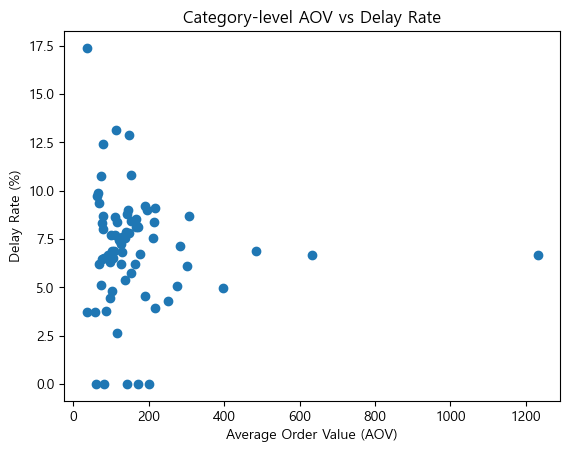

In [121]:
plt.scatter(cat_metrics_count["aov"], cat_metrics_count["delay_rate"])
plt.xlabel("Average Order Value (AOV)")
plt.ylabel("Delay Rate (%)")
plt.title("Category-level AOV vs Delay Rate")

In [126]:
print(sorted(orders.columns.tolist()))



['customer_id', 'delay_days', 'delivery_days', 'is_delayed', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_id', 'order_purchase_timestamp', 'order_status', 'purchase_date', 'purchase_dayofweek', 'purchase_hour', 'purchase_month', 'purchase_year']


In [128]:
print(sorted(oi.columns.tolist()))

['category', 'freight_value', 'order_id', 'order_item_id', 'price', 'product_id', 'seller_id', 'shipping_limit_date']


#### 배송 파생치 보장

In [131]:
# 1) 날짜형 변환 (이미 datetime이면 알아서 통과)
for c in ["order_purchase_timestamp",
          "order_estimated_delivery_date",
          "order_delivered_customer_date"]:
    if c in orders.columns:
        orders[c] = pd.to_datetime(orders[c], errors="coerce")

# 2) 파생 컬럼 생성(없으면 만들고, 있으면 유지)
if "delivery_days" not in orders.columns:
    orders["delivery_days"] = (
        orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]
    ).dt.days

if "estimated_days" not in orders.columns:
    orders["estimated_days"] = (
        orders["order_estimated_delivery_date"] - orders["order_purchase_timestamp"]
    ).dt.days

if "delay_days" not in orders.columns:
    orders["delay_days"] = orders["delivery_days"] - orders["estimated_days"]

if "is_delayed" not in orders.columns:
    # delivery_days/estimated_days가 NaN인 행은 delay_days도 NaN → 지연 여부 판단 불가
    # 판단 가능한 행에 한해 지연(>0) 처리, 그 외는 0으로 두고 별도 플래그를 만들어도 됨
    orders["is_delayed"] = (orders["delay_days"] > 0).astype(int)

# (권장) 배송 완료 건만 사용
orders_ready = orders.loc[orders["order_status"].eq("delivered")].copy()


In [133]:
# 선택: 날짜 3종이 모두 있는 행만 유지(분석 일관성 강화)
orders_ready["has_all_dates"] = orders_ready[[
    "order_purchase_timestamp","order_estimated_delivery_date","order_delivered_customer_date"
]].notna().all(axis=1)

orders_use = orders_ready.loc[orders_ready["has_all_dates"]].copy()


In [135]:
# oi: items + products(category) 조인 완료 상태라고 가정
#     (oi에는 최소한 order_id, category, order_item_id, price가 있어야 함)

orders_cat_expanded = (
    orders_use[["order_id","delivery_days","estimated_days","delay_days","is_delayed"]]
    .merge(oi[["order_id","category","order_item_id","price"]], on="order_id", how="left")
)

cat_metrics_expanded = (
    orders_cat_expanded
    .groupby("category")
    .agg(
        n_orders=("order_id","nunique"),
        n_items=("order_item_id","count"),
        sales=("price","sum"),
        avg_delivery_days=("delivery_days","mean"),
        delay_rate=("is_delayed","mean"),
    )
    .sort_values(["delay_rate","avg_delivery_days"], ascending=[False, False])
)

cat_metrics_expanded["delay_rate"] = (cat_metrics_expanded["delay_rate"]*100).round(2)
cat_metrics_expanded = cat_metrics_expanded.round({"avg_delivery_days":2, "sales":2})
display(cat_metrics_expanded.head(20))


,n_orders,n_items,sales,avg_delivery_days,delay_rate
category,,,,,
home_comfort_2,24,30,760.27,14.57,16.67
furniture_mattress_and_upholstery,37,37,4323.38,14.10,13.51
audio,348,362,50570.60,13.32,12.71
fashion_underwear_beach,117,127,9305.95,13.71,12.60
christmas_supplies,125,150,8737.84,15.48,12.00
books_technical,256,263,18702.23,10.65,11.03
home_confort,392,429,58008.45,13.24,10.26
construction_tools_lights,242,301,39957.00,9.72,9.97
food,441,499,28731.15,9.25,9.82


In [137]:
# 필수 컬럼 존재 확인(없으면 어떤 게 빠졌는지 즉시 알림)
req_orders = {"order_id","delivery_days","estimated_days","delay_days","is_delayed"}
req_oi     = {"order_id","category","order_item_id","price"}

missing_orders = req_orders - set(orders_use.columns)
missing_oi     = req_oi - set(oi.columns)
print("missing_in_orders:", missing_orders)
print("missing_in_oi:", missing_oi)


missing_in_orders: set()
missing_in_oi: set()


- 원본 컬럼 (raw) : datetime 타
    - order_purchase_timestamp (고객이 주문한 날짜·시간) : 주문일
    - order_estimated_delivery_date (시스템이 예측한 배송 완료 날짜) : 시스템이 제시한 예상 배송 완료일
    - order_delivered_customer_date (실제로 배송된 완료 날짜) : 실제 고객이 받은 날짜

- 파생 컬럼 (derived)

    - delivery_days = 실제 배송 완료일 − 주문일 → 실제로 며칠 걸렸는지
    - estimated_days = 예상 배송 완료일 − 주문일 → 시스템이 예측하기로는 며칠 걸릴 예정이었는지
    - delay_days = delivery_days − estimated_days → 실제 배송이 예상보다 며칠 빨랐는지/늦었는지
    - is_delayed = delay_days > 0 여부 → 1(지연) / 0(정상)

### 1. 상품 카테고리

In [141]:
def build_category_metrics(df, rep_col):
    m = (df.groupby(rep_col)
           .agg(
               n_orders=("order_id","nunique"),
               avg_delivery_days=("delivery_days","mean"),
               delay_rate=("is_delayed","mean"),
               aov=("order_amount","mean")
           )
           .rename_axis("category")
           .reset_index())
    m["delay_rate"] = (m["delay_rate"]*100).round(2)
    m["avg_delivery_days"] = m["avg_delivery_days"].round(2)
    m["aov"] = m["aov"].round(2)
    m["sales_total_est"] = (m["n_orders"] * m["aov"]).round(2)
    # 영향×규모 우선순위 점수
    m["sales_share"] = (m["sales_total_est"] / m["sales_total_est"].sum()).fillna(0)
    m["delay_z"] = (m["delay_rate"] - m["delay_rate"].mean()) / m["delay_rate"].std(ddof=0)
    m["priority_score"] = m["sales_share"] * (1 + m["delay_z"])
    return m.sort_values("priority_score", ascending=False)

cat_metrics_count  = build_category_metrics(orders_cat, "category_rep_count")
cat_metrics_amount = build_category_metrics(orders_cat, "category_rep_amount")

# 지연율 상위/하위, AOV 상위, '핵심 리스크'(AOV↑ & 지연율↑) 표
def ranking_views(m, top_n=10):
    r1 = m.sort_values("delay_rate", ascending=False).head(top_n)
    r2 = m.sort_values("delay_rate", ascending=True).head(top_n)
    r3 = m.sort_values("aov", ascending=False).head(top_n)
    thr_d, thr_a = m["delay_rate"].median(), m["aov"].median()
    r4 = m[(m["delay_rate"]>=thr_d)&(m["aov"]>=thr_a)].sort_values(["aov","delay_rate"], ascending=[False, False]).head(top_n)
    return r1, r2, r3, r4

rank_delay_top, rank_delay_bottom, rank_aov_top, risk_core = ranking_views(cat_metrics_count)
display(rank_delay_top, rank_delay_bottom, rank_aov_top, risk_core)


,category,n_orders,avg_delivery_days,delay_rate,aov,sales_total_est,sales_share,delay_z,priority_score
46,home_comfort_2,23,14.56,17.39,36.06,829.38,0.000062,3.473182,0.000277
41,furniture_mattress_and_upholstery,38,14.10,13.16,114.95,4368.10,0.000326,2.064059,0.000998
4,audio,350,13.47,12.86,149.36,52276.00,0.003896,1.964121,0.011549
33,fashion_underwear_beach,121,14.00,12.40,78.86,9542.06,0.000711,1.810883,0.001999
47,home_confort,351,13.40,10.83,153.75,53966.25,0.004022,1.287875,0.009203
10,books_technical,260,10.63,10.77,74.09,19263.40,0.001436,1.267887,0.003256
36,food,445,9.46,9.89,65.69,29232.05,0.002179,0.974736,0.004303
26,electronics,2542,12.88,9.72,63.54,161518.68,0.012039,0.918105,0.023091
12,christmas_supplies,128,15.06,9.38,68.88,8816.64,0.000657,0.804842,0.001186
18,construction_tools_lights,239,9.83,9.21,189.32,45247.48,0.003372,0.748210,0.005896


,category,n_orders,avg_delivery_days,delay_rate,aov,sales_total_est,sales_share,delay_z,priority_score
52,la_cuisine,11,7.09,0.00,172.18,1893.98,0.000141,-2.319881,-0.000186
59,pc_gamer,7,10.21,0.00,202.28,1415.96,0.000106,-2.319881,-0.000139
11,cds_dvds_musicals,12,10.92,0.00,60.83,729.96,0.000054,-2.319881,-0.000072
29,fashion_childrens_clothes,6,9.42,0.00,81.64,489.84,0.000037,-2.319881,-0.000048
63,security_and_services,2,15.14,0.00,141.64,283.28,0.000021,-2.319881,-0.000028
58,party_supplies,38,9.05,2.63,115.93,4405.34,0.000328,-1.443760,-0.000146
23,diapers_and_hygiene,27,10.49,3.70,58.06,1567.62,0.000117,-1.087315,-0.000010
35,flowers,27,11.82,3.70,37.90,1023.30,0.000076,-1.087315,-0.000007
9,books_imported,53,8.18,3.77,87.78,4652.34,0.000347,-1.063996,-0.000022
1,air_conditioning,253,11.88,3.95,218.21,55207.13,0.004115,-1.004033,-0.000017


,category,n_orders,avg_delivery_days,delay_rate,aov,sales_total_est,sales_share,delay_z,priority_score
14,computers,180,13.84,6.67,1230.96,221572.80,0.016515,-0.097930,0.014898
66,small_appliances_home_oven_and_coffee,75,9.93,6.67,632.61,47445.75,0.003536,-0.097930,0.003190
45,home_appliances_2,233,13.28,6.87,485.70,113168.10,0.008435,-0.031305,0.008171
0,agro_industry_and_commerce,182,11.43,4.95,398.52,72530.64,0.005406,-0.670907,0.001779
56,musical_instruments,623,12.91,8.67,307.11,191329.53,0.014261,0.568322,0.022365
65,small_appliances,625,11.01,6.08,302.93,189331.25,0.014112,-0.294474,0.009956
62,portateis_cozinha_e_preparadores_de_alimentos,14,8.44,7.14,283.47,3968.58,0.000296,0.058639,0.000313
34,fixed_telephony,217,12.53,5.07,274.94,59661.98,0.004447,-0.630932,0.001641
19,construction_tools_safety,163,11.71,4.29,251.36,40971.68,0.003054,-0.890770,0.000334
1,air_conditioning,253,11.88,3.95,218.21,55207.13,0.004115,-1.004033,-0.000017


,category,n_orders,avg_delivery_days,delay_rate,aov,sales_total_est,sales_share,delay_z,priority_score
56,musical_instruments,623,12.91,8.67,307.11,191329.53,0.014261,0.568322,0.022365
62,portateis_cozinha_e_preparadores_de_alimentos,14,8.44,7.14,283.47,3968.58,0.000296,0.058639,0.000313
57,office_furniture,1263,20.36,9.11,216.17,273022.71,0.020350,0.714898,0.034897
72,watches_gifts,5584,12.76,8.38,214.73,1199052.32,0.089371,0.471716,0.131528
38,furniture_bedroom,93,13.84,7.53,212.02,19717.86,0.001470,0.188559,0.001747
17,construction_tools_construction,743,10.81,9.02,196.26,145821.18,0.010869,0.684916,0.018313
18,construction_tools_lights,239,9.83,9.21,189.32,45247.48,0.003372,0.748210,0.005896
48,home_construction,467,13.29,8.14,172.59,80599.53,0.006007,0.391765,0.008361
50,industry_commerce_and_business,232,10.93,8.19,169.82,39398.24,0.002937,0.408422,0.004136
55,music,37,11.56,8.11,165.92,6139.04,0.000458,0.381772,0.000632


In [142]:
# orders_cat에 반드시 있어야 하는 컬럼
need_cols = {
    "order_id","delivery_days","is_delayed",
    "category_rep_count","category_rep_amount"
}
print("missing in orders_cat:", need_cols - set(orders_cat.columns))


missing in orders_cat: set()


#### 랭킹 뷰(지연 Top/Bottom, AOV Top, 핵심 리스크)

In [146]:
def ranking_views(m, top_n=10):
    r1 = m.sort_values("delay_rate", ascending=False).head(top_n)
    r2 = m.sort_values("delay_rate", ascending=True).head(top_n)
    r3 = m.sort_values("aov",        ascending=False).head(top_n)
    thr_d, thr_a = m["delay_rate"].median(), m["aov"].median()
    r4 = (m[(m["delay_rate"]>=thr_d)&(m["aov"]>=thr_a)]
          .sort_values(["aov","delay_rate"], ascending=[False, False])
          .head(top_n))
    return r1, r2, r3, r4

rank_delay_top, rank_delay_bottom, rank_aov_top, risk_core = ranking_views(cat_metrics_count)
display(rank_delay_top, rank_delay_bottom, rank_aov_top, risk_core)


,category,n_orders,avg_delivery_days,delay_rate,aov,sales_total_est,sales_share,delay_z,priority_score
46,home_comfort_2,23,14.56,17.39,36.06,829.38,0.000062,3.473182,0.000277
41,furniture_mattress_and_upholstery,38,14.10,13.16,114.95,4368.10,0.000326,2.064059,0.000998
4,audio,350,13.47,12.86,149.36,52276.00,0.003896,1.964121,0.011549
33,fashion_underwear_beach,121,14.00,12.40,78.86,9542.06,0.000711,1.810883,0.001999
47,home_confort,351,13.40,10.83,153.75,53966.25,0.004022,1.287875,0.009203
10,books_technical,260,10.63,10.77,74.09,19263.40,0.001436,1.267887,0.003256
36,food,445,9.46,9.89,65.69,29232.05,0.002179,0.974736,0.004303
26,electronics,2542,12.88,9.72,63.54,161518.68,0.012039,0.918105,0.023091
12,christmas_supplies,128,15.06,9.38,68.88,8816.64,0.000657,0.804842,0.001186
18,construction_tools_lights,239,9.83,9.21,189.32,45247.48,0.003372,0.748210,0.005896


,category,n_orders,avg_delivery_days,delay_rate,aov,sales_total_est,sales_share,delay_z,priority_score
52,la_cuisine,11,7.09,0.00,172.18,1893.98,0.000141,-2.319881,-0.000186
59,pc_gamer,7,10.21,0.00,202.28,1415.96,0.000106,-2.319881,-0.000139
11,cds_dvds_musicals,12,10.92,0.00,60.83,729.96,0.000054,-2.319881,-0.000072
29,fashion_childrens_clothes,6,9.42,0.00,81.64,489.84,0.000037,-2.319881,-0.000048
63,security_and_services,2,15.14,0.00,141.64,283.28,0.000021,-2.319881,-0.000028
58,party_supplies,38,9.05,2.63,115.93,4405.34,0.000328,-1.443760,-0.000146
23,diapers_and_hygiene,27,10.49,3.70,58.06,1567.62,0.000117,-1.087315,-0.000010
35,flowers,27,11.82,3.70,37.90,1023.30,0.000076,-1.087315,-0.000007
9,books_imported,53,8.18,3.77,87.78,4652.34,0.000347,-1.063996,-0.000022
1,air_conditioning,253,11.88,3.95,218.21,55207.13,0.004115,-1.004033,-0.000017


,category,n_orders,avg_delivery_days,delay_rate,aov,sales_total_est,sales_share,delay_z,priority_score
14,computers,180,13.84,6.67,1230.96,221572.80,0.016515,-0.097930,0.014898
66,small_appliances_home_oven_and_coffee,75,9.93,6.67,632.61,47445.75,0.003536,-0.097930,0.003190
45,home_appliances_2,233,13.28,6.87,485.70,113168.10,0.008435,-0.031305,0.008171
0,agro_industry_and_commerce,182,11.43,4.95,398.52,72530.64,0.005406,-0.670907,0.001779
56,musical_instruments,623,12.91,8.67,307.11,191329.53,0.014261,0.568322,0.022365
65,small_appliances,625,11.01,6.08,302.93,189331.25,0.014112,-0.294474,0.009956
62,portateis_cozinha_e_preparadores_de_alimentos,14,8.44,7.14,283.47,3968.58,0.000296,0.058639,0.000313
34,fixed_telephony,217,12.53,5.07,274.94,59661.98,0.004447,-0.630932,0.001641
19,construction_tools_safety,163,11.71,4.29,251.36,40971.68,0.003054,-0.890770,0.000334
1,air_conditioning,253,11.88,3.95,218.21,55207.13,0.004115,-1.004033,-0.000017


,category,n_orders,avg_delivery_days,delay_rate,aov,sales_total_est,sales_share,delay_z,priority_score
56,musical_instruments,623,12.91,8.67,307.11,191329.53,0.014261,0.568322,0.022365
62,portateis_cozinha_e_preparadores_de_alimentos,14,8.44,7.14,283.47,3968.58,0.000296,0.058639,0.000313
57,office_furniture,1263,20.36,9.11,216.17,273022.71,0.020350,0.714898,0.034897
72,watches_gifts,5584,12.76,8.38,214.73,1199052.32,0.089371,0.471716,0.131528
38,furniture_bedroom,93,13.84,7.53,212.02,19717.86,0.001470,0.188559,0.001747
17,construction_tools_construction,743,10.81,9.02,196.26,145821.18,0.010869,0.684916,0.018313
18,construction_tools_lights,239,9.83,9.21,189.32,45247.48,0.003372,0.748210,0.005896
48,home_construction,467,13.29,8.14,172.59,80599.53,0.006007,0.391765,0.008361
50,industry_commerce_and_business,232,10.93,8.19,169.82,39398.24,0.002937,0.408422,0.004136
55,music,37,11.56,8.11,165.92,6139.04,0.000458,0.381772,0.000632


In [148]:
out = pd.concat([
    rank_delay_top.assign(view="delay_top"),
    rank_delay_bottom.assign(view="delay_bottom"),
    rank_aov_top.assign(view="aov_top"),
    risk_core.assign(view="risk_core")
], ignore_index=True)
display(out.head())


,category,n_orders,avg_delivery_days,delay_rate,aov,sales_total_est,sales_share,delay_z,priority_score,view
0,home_comfort_2,23,14.56,17.39,36.06,829.38,0.000062,3.473182,0.000277,delay_top
1,furniture_mattress_and_upholstery,38,14.10,13.16,114.95,4368.10,0.000326,2.064059,0.000998,delay_top
2,audio,350,13.47,12.86,149.36,52276.00,0.003896,1.964121,0.011549,delay_top
3,fashion_underwear_beach,121,14.00,12.40,78.86,9542.06,0.000711,1.810883,0.001999,delay_top
4,home_confort,351,13.40,10.83,153.75,53966.25,0.004022,1.287875,0.009203,delay_top


#### 리뷰 데이터도 사용해볼까...

In [151]:
reviews = pd.read_csv("./data/olist_order_reviews_dataset.csv")
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [152]:
import numpy as np
import pandas as pd

# 1) 기준치: 전사 또는 카테고리별 중앙값(전사 기준 예시)
fast_thr = orders_ready["delivery_days"].median()
orders_ready["speed_bucket"] = np.where(orders_ready["delivery_days"] <= fast_thr, "fast", "slow")
orders_ready["on_time"] = (orders_ready["delay_days"] <= 0).astype(int)

# 2) 리뷰 결합(만족도 프록시)
rev = reviews[["order_id","review_score"]].copy()
rev["is_positive"] = (rev["review_score"] >= 4).astype(int)

j = orders_ready.merge(rev, on="order_id", how="left")

# 3) 2×2 결과표
mat = (j.groupby(["speed_bucket","on_time"])
         .agg(
             n_orders=("order_id","nunique"),
             pos_rate=("is_positive","mean"),
             avg_score=("review_score","mean"),
             avg_delivery_days=("delivery_days","mean"),
             avg_delay_days=("delay_days","mean")
         )
         .reset_index()
         .replace({"on_time": {1:"on_time", 0:"late"}}))
mat


,speed_bucket,on_time,n_orders,pos_rate,avg_score,avg_delivery_days,avg_delay_days
0,fast,late,454,0.764574,4.073991,6.771665,1.577152
1,fast,on_time,47781,0.854084,4.387177,6.432305,0.000000
2,slow,late,7380,0.320986,2.476040,31.946710,10.041365
3,slow,on_time,40863,0.796937,4.184496,16.092057,0.000000


#### 변수 생성
- speed_bucket
    - delivery_days (실제 배송 걸린 일수) 기준으로 중앙값 이하이면 빠름, 초과면 느림으로
- on_time
    - late: 지연
    - on_time: 정시
- pos_rate
    - 그 셀에 속한 주문들의 긍정 리뷰 비율

#### 2x2 표 해석
**정시성(on_time)**이 만족도에 훨씬 큰 영향.

- fast이면서 on_time의 pos_rate(긍정 리뷰 비율)≈0.854
    -  ↔ fast이면서 late의 pos_rate(긍정 리뷰 비율) ≈0.765
    -  fast그룹 안에서 정시(on_time)에서 지연(late)으로 바뀌었을 때 → -8.9%p (8.9%가 떨어짐)
- slow이면서 on_time의 pos_rate(긍정 리뷰 비율)≈0.797
    - ↔ slow이면서 late의 pos_rate(긍정 리뷰 비율) ≈0.321
    - slow그룹 안에서 정시에서 지연으로 바뀌었을 때 → -47.6%p(47.6%가 떨어짐)

**속도(절대 일수)**의 영향은 그 다음.

- on_time(정시) 조건에서 fast vs slow 차이는 +5.7%p 정도.
- late인 경우에도 “얼마나 늦었는지(평균 +1.6일 vs +10일)”가 만족도에 크게 작용.

# 방향성 수정

- 기존: “배송일수가 줄면 만족↑?”
- 개정: “속도 vs 정시성 중 무엇이 만족·매출에 더 큰 영향을 주는가?”

-> 데이터 분석 결과 정시성이 더 큰 영향 줌

#### 요구사항
"거기서 어떤 내용을 3,4번을 하게된 분석 결과로 이끌 수 있을지 잘 뽑아주면 좋을거같아"

- 정시성이 매출 및 만족에 큰 영향을 줌
- 목표 = 기업의 이윤 극대화 = 주문 고객의 만족도 높이기
    - 배송이 지연되는 원인을 파악
    - 문제 해결 = 물류배송의 위치 선정

#### 2x2 셀의 차이(%p)와 95%CI

In [161]:
import numpy as np
import pandas as pd

# mat: columns = ["speed_bucket","on_time","n_orders","pos_rate", ...]
# on_time 값이 1/0일 수도, "on_time"/"late"일 수도 있어 보정
mt = mat.copy()
mt["on_time"] = mt["on_time"].map({1:"on_time", 0:"late"}).fillna(mt["on_time"])

def pick(speed, status):
    r = mt.query("speed_bucket == @speed and on_time == @status").iloc[0]
    return float(r["pos_rate"]), int(r["n_orders"])

def diff_pp_ci(p_on, n_on, p_la, n_la, z=1.96):
    # 차이(퍼센트포인트)와 95% CI
    diff = (p_on - p_la) * 100
    se   = np.sqrt(p_on*(1-p_on)/n_on + p_la*(1-p_la)/n_la) * 100
    return diff, diff - z*se, diff + z*se

# fast 그룹: on_time vs late
pf_on, nf_on = pick("fast", "on_time")
pf_la, nf_la = pick("fast", "late")
fast_diff, fast_ci_low, fast_ci_high = diff_pp_ci(pf_on, nf_on, pf_la, nf_la)

# slow 그룹: on_time vs late
ps_on, ns_on = pick("slow", "on_time")
ps_la, ns_la = pick("slow", "late")
slow_diff, slow_ci_low, slow_ci_high = diff_pp_ci(ps_on, ns_on, ps_la, ns_la)

effect = pd.DataFrame({
    "bucket": ["fast","slow"],
    "pos_rate_on_time":[pf_on, ps_on],
    "pos_rate_late":   [pf_la, ps_la],
    "diff_pp(ON-LATE)":[fast_diff, slow_diff],
    "CI_low":          [fast_ci_low, slow_ci_low],
    "CI_high":         [fast_ci_high, slow_ci_high],
}).round(3)

display(effect)


,bucket,pos_rate_on_time,pos_rate_late,diff_pp(ON-LATE),CI_low,CI_high
0,fast,0.854,0.765,8.951,5.035,12.866
1,slow,0.797,0.321,47.595,46.461,48.729


- 95% CI란?
    - 95% 신뢰 구간: 같은 절차로 표본을 무한 반복했을 때 그중 약 95%의 구간이 모수의 진짜 값을 포함한다는 절차의 장기적 성질을 뜻함
    - 모집단에서 표본추출, 계산을 계속 반복해서 얻은 구간들 중 약 95%가 진짜 값을 포함한다는 뜻
    - 특정 구간이 95%확률로 진짜 값을 담는다는 뜻이 아님
- CI 해석
    - CI가 0 포함
        - 표본 오차를 고려할 때 '차이가 없다'는 가능성도 배제 못함.
        - 통계적으로 불확실
    - CI가 0 포함 x
        - 그 차이가 0이 아니라는 증거가 95%수준에서 충분함.
        - 0.05 유의수준의 양측 검정에서 유의와 동치

- 정시(on time)일 때 긍정 비율 - 지연(late)일 때 긍정비율을 구하고 그 차이에 대한 95% 신뢰구간 계산

#### 표 결과 해석
- fast
    - on time이 late보다 +8.951%p 높고, CI [+5.035, +12.866]
    - → 0을 완전히 넘어선다 → 유의하게 긍정비율이 더 높다.

- slow

    - on-time가 late보다 +47.595%p 높고, CI [+46.461, +48.729]
    - → 효과가 훨씬 크고 매우 안정적.

정시성(약속 준수)이 만족도에 강하게 작용하며, 특히 느린 배송군에서 격차가 압도적.

#### 2x2표와 결과 같은데 신뢰구간 알아본 이유

- 2x2 표의 차이가 얼마나 신뢰할 수 있는지 모르기 때문
- 

### 상호 작용 분석 - 카테고리 x 가격대별 on-time 민감도

In [167]:

# 1) 가격대 버킷(전사 기준 3분위; 필요하면 카테고리별 분위수로 바꿔도 됨)
q1, q2 = orders_cat["order_amount"].quantile([0.33, 0.66])
base = orders_cat.merge(reviews[["order_id","review_score"]], on="order_id", how="left").copy()
base["is_positive"] = (base["review_score"] >= 4).astype(int)
base["on_time"] = (base["delay_days"] <= 0).astype(int)
base["price_bucket"] = pd.cut(base["order_amount"],
                              bins=[-1e18, q1, q2, 1e18],
                              labels=["low","mid","high"])

# 2) 카테고리×가격대×정시성 교차표
panel = (base.groupby(["category_rep_count","price_bucket","on_time"])
             .agg(n=("order_id","nunique"),
                  pos=("is_positive","mean"))
             .reset_index())

# 3) on_time vs late 비율차(퍼센트포인트) + 표본수
wide = (panel.pivot(index=["category_rep_count","price_bucket"],
                    columns="on_time", values=["pos","n"]))
wide.columns = [f"{a}_{b}" for a,b in wide.columns.to_flat_index()]  # pos_0,pos_1,n_0,n_1
wide = wide.fillna(0)
wide["gap_pp"] = (wide["pos_1"] - wide["pos_0"]) * 100
wide["n_total"] = wide["n_0"] + wide["n_1"]
wide = wide.reset_index()

# 4) 95% CI(두 비율 차이)까지 계산해서 “확실성” 포함 랭킹
z = 1.96
se = np.sqrt(wide["pos_1"]*(1-wide["pos_1"])/wide["n_1"].clip(lower=1) +
             wide["pos_0"]*(1-wide["pos_0"])/wide["n_0"].clip(lower=1)) * 100
wide["ci_low"]  = wide["gap_pp"] - z*se
wide["ci_high"] = wide["gap_pp"] + z*se

# 5) 표본수 하한(예: 200건) 걸고, “보수적 효과(ci_low)” 기준 정렬
sensitive = (wide.query("n_total >= 200")
                  .sort_values(["ci_low","gap_pp","n_total"], ascending=[False, False, False]))
display(sensitive.head(20))  # on-time 민감 카테고리×가격대 Top-20


C:\Users\charl\AppData\Local\Temp\ipykernel_19176\471927072.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel = (base.groupby(["category_rep_count","price_bucket","on_time"])


,category_rep_count,price_bucket,pos_0,pos_1,n_0,n_1,gap_pp,n_total,ci_low,ci_high
85,fashion_bags_accessories,mid,0.120000,0.834423,25.0,456.0,71.442266,481.0,58.254822,84.629710
62,cool_stuff,high,0.220430,0.840653,185.0,1772.0,62.022305,1957.0,55.810421,68.234188
218,watches_gifts,high,0.230000,0.829375,400.0,2735.0,59.937523,3135.0,55.579040,64.296005
202,sports_leisure,mid,0.256604,0.865611,265.0,2700.0,60.900742,2965.0,55.486999,66.314485
206,stationery,high,0.208955,0.865421,66.0,535.0,65.646534,601.0,55.420413,75.872655
203,sports_leisure,high,0.242525,0.830154,300.0,2184.0,58.762949,2484.0,53.663502,63.862396
215,toys,high,0.250000,0.855576,118.0,1094.0,60.557587,1212.0,52.471710,68.643464
126,garden_tools,low,0.273438,0.870389,126.0,998.0,59.695133,1124.0,51.638175,67.752092
20,baby,high,0.183824,0.761795,136.0,869.0,57.797164,1005.0,50.697747,64.896581
19,baby,mid,0.252874,0.852518,87.0,832.0,59.964442,919.0,50.518317,69.410567


#### 상호작용 분석의 차별성

- 앞에서 만든 2x2 결과를 그냥 반복하는게 아님
- 그 결론을 세그먼트별로 쪼개서 어디서 얼마나 다른지 밝히는 단계

1. 평균 -> 이질성으로 확대
- 앞에서는 평균에서 정시성 효과가 크다는 '전반적 사실 확인'
- 상호작용 단계
    - 같은 효과가 카테고리, 가격대에 따라 얼마나 달라지는지 효과의 기울기 차이를 측정
    - ex) 고가 가구는 ontime, late 격차가 60%p, 저가 패션은 10%p

2. 공정한 비교
- 카테고리마다 '보통 배송일수'가 다름
- 카테고리별 중앙값 기준으로 fast/slow를 나눠서 공정성 확보
- 동일 카테고리 안에서의 비교라서 상품 특성 차이가 덜 섞임

3. 투자 우선순위 산출의 단위가 바뀜
- 전체 평균만 보면 '정시성 중요'에서 끝
- 상호작용
    - 어떤 카테고리x가격대에 돈을 써야 확실히 만족/매출이 나온다 ->라는 결론 나옴

- pos_0, pos_1
    - late(0: 지연), on_time(1: 정시) 일 때의 긍정 리뷰 비율
 
- ci_low(하한), ci_high(상한)

    - gap_pp의 95% 신뢰구간
    - 하한이 0보다 크면 정시가 더 유의하게 좋다는 근

- gap_pp

    - (pos_1-pos_0)*100
    - 정시의 리뷰 개선 효과(퍼센트 포인트)
 
- n_0, n_1

    - 각 조건의 표본 수(정시, 지연의 표본 수)
 
- n_total

    - n_0 +n_1
 
- price_bucket

    - 기준: 전사 분위수로 선택

#### 한 줄 결론

- 정시성 효과(gap_pp)가 크고 하한(ci_low)도 높고 n_total도 큰 조합을 1순위 타깃
- 표에서 볼 수 있듯이 고가, 선물성 카테고리에서 정시성의 ROI가 특히 큼
    - EDD(예상일) 보수화, 출고 SLA 강화, 대체 라인/택배사, 분리 배송 안내를 우선 적용...?

### 지연 원인 분해

[진단] pairs: 100,010 | 좌표누락비율: 0.50% | 거리계산 유효행: 99,511 | order_dist 주문수: 98,177
[Logistic] ROC-AUC: 0.7135
[Logistic] Classification report:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78     18324
           1       0.14      0.66      0.23      1565

    accuracy                           0.66     19889
   macro avg       0.55      0.66      0.51     19889
weighted avg       0.89      0.66      0.74     19889


[Logistic] 계수 TOP 15 (절대값 기준):
order_month_2016-10   -2.262005
order_month_2018-03    1.563169
order_month_2018-06   -1.464224
order_month_2018-02    1.201157
order_month_2017-11    1.081630
order_month_2018-08    0.866244
order_month_2017-01   -0.575103
order_month_2017-08   -0.510634
order_month_2018-05    0.488239
order_month_2017-12    0.480753
order_month_2017-02   -0.474917
order_month_2017-07   -0.465901
order_month_2017-04    0.340804
order_month_2017-05   -0.321894
order_month_2017-06   -0.287096
dtype: float64

[Ran

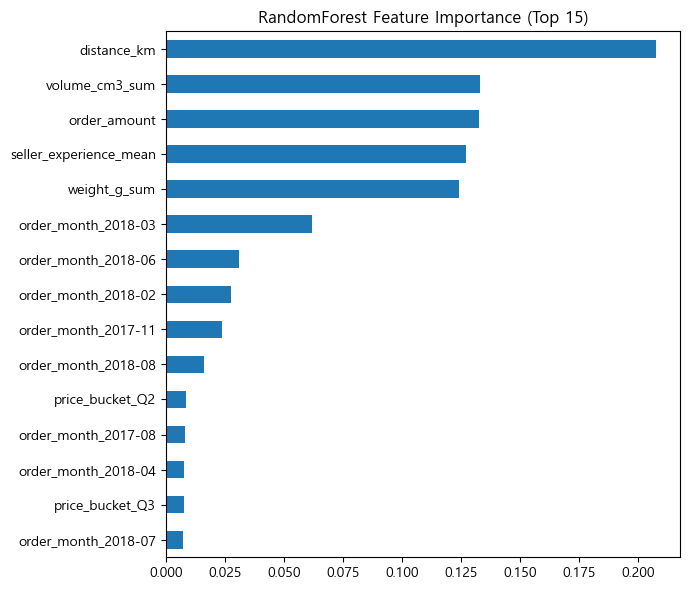


[요약] 지연 영향 요인(로지스틱 계수 + RF 중요도 결합 상위 20):
                   feature  logistic_coef  rf_importance  abs_coef_rank  \
0      order_month_2018-03       1.563169       0.061783            2.0   
1      order_month_2018-06      -1.464224       0.030848            3.0   
2      order_month_2018-02       1.201157       0.027805            4.0   
3      order_month_2017-11       1.081630       0.023778            5.0   
4      order_month_2018-08       0.866244       0.016062            6.0   
5              distance_km       0.237546       0.207356           16.0   
6      order_month_2017-08      -0.510634       0.008344            8.0   
7             weight_g_sum       0.088546       0.124282           22.0   
8      order_month_2017-07      -0.465901       0.007188           12.0   
9      order_month_2017-12       0.480753       0.006907           10.0   
10     order_month_2018-05       0.488239       0.006394            9.0   
11          volume_cm3_sum      -0.023231       0.132864 

In [180]:
# -*- coding: utf-8 -*-
# 지연 원인 분석: Olist 예제 데이터 기준 완결 파이프라인
# 필요 패키지
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 0. 데이터 로딩 
items = pd.read_csv("./data/olist_order_items_dataset.csv")
orders = pd.read_csv("./data/olist_orders_dataset.csv")
products = pd.read_csv("./data/olist_products_dataset.csv")
customers = pd.read_csv("./data/olist_customers_dataset.csv")
sellers = pd.read_csv("./data/olist_sellers_dataset.csv")
geolocation = pd.read_csv("./data/olist_geolocation_dataset.csv")

# 여기서는 질문자가 이미 다음 변수를 메모리에 갖고 있다고 가정:
# items, orders_cat, products, customers, sellers, geo


# -------------------------------------------------------------------
# 0. 데이터 로딩 (이미 로드되어 있다면 이 블록은 생략)
# -------------------------------------------------------------------
# 질문자 코드에서는 items, orders_cat, products, customers, sellers 는 이미 있음
# geolocation 데이터만 import 안 해서 geo가 없었던 게 문제였음.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# ✅ geo 보완: geolocation을 불러오고 geo 별칭 생성
if 'geo' not in globals():
    geolocation = pd.read_csv("./data/olist_geolocation_dataset.csv")
    geo = geolocation.copy()

# -------------------------------------------------------------------
# 2. 지오코딩 기반 고객-판매자 거리 계산 (이제 geo 변수는 존재함)
# -------------------------------------------------------------------
geo["geolocation_zip_code_prefix"] = geo["geolocation_zip_code_prefix"].astype(str)
customers["customer_zip_code_prefix"] = customers["customer_zip_code_prefix"].astype(str)
sellers["seller_zip_code_prefix"] = sellers["seller_zip_code_prefix"].astype(str)

geo_slim = geo[["geolocation_zip_code_prefix","geolocation_lat","geolocation_lng"]].drop_duplicates("geolocation_zip_code_prefix")
cust_geo = (customers.merge(geo_slim, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left")
                    .rename(columns={"geolocation_lat":"cust_lat","geolocation_lng":"cust_lng"})
                    [["customer_id","cust_lat","cust_lng"]])
sell_geo = (sellers.merge(geo_slim, left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left")
                  .rename(columns={"geolocation_lat":"sell_lat","geolocation_lng":"sell_lng"})
                  [["seller_id","sell_lat","sell_lng"]])

# 이후 코드는 네가 보내준 원본과 동일하게 계속 이어짐...
# order_dist, n_sellers, order_exp, order_attr, feat 생성 → 모델링 → summary 출력

# -------------------------------------------------------------------
# 1. 유틸/헬퍼
# -------------------------------------------------------------------
def ensure_str(s):
    """우편번호 prefix 등 숫자형으로 읽힌 키를 문자열로 통일"""
    return s.astype(str)

def haversine(lat1, lon1, lat2, lon2):
    """벡터화 하버사인 거리(km)"""
    R = 6371.0088
    lat1,lon1,lat2,lon2 = map(np.radians, [lat1,lon1,lat2,lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def safe_make_is_delayed(df):
    """
    타깃 변수 정합성:
    - is_delayed가 있으면 그대로 사용.
    - 없고 delay_days가 있으면 delay_days>0 로 지연 정의.
    - 둘 다 없으면 0(지연 아님)으로 대체(임시).
    """
    if "is_delayed" in df.columns:
        return df["is_delayed"].astype(int)
    elif "delay_days" in df.columns:
        return (df["delay_days"] > 0).astype(int)
    else:
        return pd.Series(0, index=df.index, dtype=int)

def safe_make_on_time(df):
    """on_time 파생: is_delayed가 있으면 1-is_delayed, 없으면 delay_days<=0"""
    if "on_time" in df.columns:
        return df["on_time"].astype(int)
    if "is_delayed" in df.columns:
        return (df["is_delayed"] == 0).astype(int)
    if "delay_days" in df.columns:
        return (df["delay_days"] <= 0).astype(int)
    return pd.Series(0, index=df.index, dtype=int)

def safe_order_amount(orders_cat, items):
    """
    order_amount가 없으면 items기반 합계(price+freight_value)로 생성.
    (freight_value가 없다면 price 합으로 대체)
    """
    if "order_amount" in orders_cat.columns:
        return orders_cat["order_amount"]
    need = ["order_id","price"]
    freight_exists = "freight_value" in items.columns
    if freight_exists: need.append("freight_value")
    tmp = items[need].copy()
    if freight_exists:
        tmp["amt"] = tmp["price"].fillna(0) + tmp["freight_value"].fillna(0)
    else:
        tmp["amt"] = tmp["price"].fillna(0)
    order_amt = tmp.groupby("order_id")["amt"].sum().rename("order_amount")
    return orders_cat.merge(order_amt, on="order_id", how="left")["order_amount"]

def safe_price_bucket(order_amount, q=4):
    """가격 분위 구간. 결측/동점 많을 때 예외 방지를 위해 rank→qcut."""
    if order_amount.isna().all():
        # 전부 결측이면 단일 구간
        return pd.Series(["Q1"] * len(order_amount), index=order_amount.index, dtype="object")
    r = order_amount.fillna(order_amount.median()).rank(method="first")
    labels = [f"Q{i}" for i in range(1, q+1)]
    return pd.qcut(r, q=q, labels=labels, duplicates="drop")

def safe_category_rep_count(items, products):
    """
    주문 내 고유 카테고리 수(없으면 product_id 수로 대체)
    products에 'product_category_name' 또는 'product_category_name_english' 있으면 사용.
    """
    key = None
    if "product_category_name_english" in products.columns:
        key = "product_category_name_english"
    elif "product_category_name" in products.columns:
        key = "product_category_name"
    if key is None:
        # 카테고리가 전혀 없으면 product_id의 고유개수로 대체
        return items.groupby("order_id")["product_id"].nunique().rename("category_rep_count").reset_index()

    tmp = items.merge(products[["product_id", key]], on="product_id", how="left")
    cat_cnt = (tmp.groupby("order_id")[key]
                 .nunique()
                 .rename("category_rep_count")
                 .reset_index())
    return cat_cnt

# -------------------------------------------------------------------
# 2. 지오코딩 기반 고객-판매자 거리 계산
# -------------------------------------------------------------------
# ZIP prefix dtype 정리
geo["geolocation_zip_code_prefix"] = ensure_str(geo["geolocation_zip_code_prefix"])
customers["customer_zip_code_prefix"] = ensure_str(customers["customer_zip_code_prefix"])
sellers["seller_zip_code_prefix"] = ensure_str(sellers["seller_zip_code_prefix"])

# 고객/판매자 위경도 테이블
geo_slim = geo[["geolocation_zip_code_prefix","geolocation_lat","geolocation_lng"]].drop_duplicates("geolocation_zip_code_prefix")
cust_geo = (customers.merge(geo_slim, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left")
                    .rename(columns={"geolocation_lat":"cust_lat","geolocation_lng":"cust_lng"})
                    [["customer_id","cust_lat","cust_lng"]])
sell_geo = (sellers.merge(geo_slim, left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left")
                  .rename(columns={"geolocation_lat":"sell_lat","geolocation_lng":"sell_lng"})
                  [["seller_id","sell_lat","sell_lng"]])

# 주문×판매자 가격합
oi_price = items.groupby(["order_id","seller_id"], as_index=False)["price"].sum()

# 주문-고객 매핑이 orders_cat에 존재한다고 가정(없으면 orders에서 가져오기)
if "customer_id" not in orders_cat.columns:
    # 예비: orders에서 끌고오기
    # orders_cat = orders_cat.merge(orders[["order_id","customer_id"]], on="order_id", how="left")
    pass

pairs = (oi_price
         .merge(orders_cat[["order_id","customer_id"]], on="order_id", how="left")
         .merge(cust_geo, on="customer_id", how="left")
         .merge(sell_geo, on="seller_id", how="left"))

coord_na = pairs[["cust_lat","cust_lng","sell_lat","sell_lng"]].isna().any(axis=1)
valid = pairs.loc[~coord_na].copy()
valid = valid[valid["price"] > 0]  # 0원 가중치 제거
valid["dist_km"] = haversine(valid["cust_lat"], valid["cust_lng"], valid["sell_lat"], valid["sell_lng"])
valid["w_dist"] = valid["dist_km"] * valid["price"]

order_dist = (valid.groupby("order_id", as_index=False)
                    .agg(w_dist_sum=("w_dist","sum"), w_sum=("price","sum")))
order_dist["distance_km"] = order_dist["w_dist_sum"] / order_dist["w_sum"]
order_dist = order_dist[["order_id","distance_km"]]

print(f"[진단] pairs: {len(pairs):,} | 좌표누락비율: {coord_na.mean()*100:.2f}% | 거리계산 유효행: {len(valid):,} | order_dist 주문수: {order_dist['order_id'].nunique():,}")

# -------------------------------------------------------------------
# 3. 판매자 수 / 판매자 경험 / 무게·부피 피처
# -------------------------------------------------------------------
# 판매자 수
n_sellers = items.groupby("order_id")["seller_id"].nunique().rename("n_sellers").reset_index()

# 판매자 경험(간단): 판매자별 누적 '주문 수'
if "order_purchase_timestamp" in orders_cat.columns:
    ord_time = orders_cat[["order_id","order_purchase_timestamp"]].copy()
else:
    # 없으면 더미(경험값 평균이 동일해져도 모델은 다른 피처로 설명)
    ord_time = items[["order_id"]].drop_duplicates()
    ord_time["order_purchase_timestamp"] = pd.NaT

sell_hist = (items.merge(ord_time, on="order_id", how="left")
                  .groupby("seller_id")["order_id"].nunique()
                  .rename("seller_total_orders").reset_index())

order_exp = (items[["order_id","seller_id"]]
             .merge(sell_hist, on="seller_id", how="left")
             .groupby("order_id")["seller_total_orders"].mean()
             .rename("seller_experience_mean").reset_index())

# 무게/부피
pp = products[["product_id","product_weight_g","product_length_cm","product_height_cm","product_width_cm"]].copy()
pp["volume_cm3"] = pp["product_length_cm"] * pp["product_height_cm"] * pp["product_width_cm"]
oi_attr = items.merge(pp, on="product_id", how="left")
order_attr = (oi_attr.groupby("order_id")
              .agg(
                  weight_g_sum=("product_weight_g","sum"),
                  volume_cm3_sum=("volume_cm3","sum"),
                  weight_g_max=("product_weight_g","max"),
                  volume_cm3_max=("volume_cm3","max")
              ).reset_index())

# -------------------------------------------------------------------
# 4. 타깃/파생: is_delayed, on_time, order_amount, price_bucket, category_rep_count, order_month
# -------------------------------------------------------------------
orders_cat = orders_cat.copy()
orders_cat["is_delayed"] = safe_make_is_delayed(orders_cat)
orders_cat["on_time"] = safe_make_on_time(orders_cat)

# order_amount
orders_cat["order_amount"] = safe_order_amount(orders_cat, items)

# price_bucket
orders_cat["price_bucket"] = safe_price_bucket(orders_cat["order_amount"], q=4)

# category_rep_count (주문 내 고유 카테고리 수)
cat_cnt = safe_category_rep_count(items, products)  # (order_id, category_rep_count)
orders_cat = orders_cat.merge(cat_cnt, on="order_id", how="left")

# order_month
if "order_purchase_timestamp" in orders_cat.columns:
    orders_cat["order_month"] = pd.to_datetime(orders_cat["order_purchase_timestamp"]).dt.to_period("M").astype(str)
else:
    orders_cat["order_month"] = "unknown"

# -------------------------------------------------------------------
# 5. 피처 테이블 결합
# -------------------------------------------------------------------
feat = (orders_cat[["order_id","is_delayed","delay_days","on_time","order_amount",
                    "category_rep_count","price_bucket","order_month"]]
        .merge(order_dist, on="order_id", how="left")
        .merge(n_sellers, on="order_id", how="left")
        .merge(order_attr, on="order_id", how="left")
        .merge(order_exp, on="order_id", how="left"))

# 결측 보정
for c in ["distance_km","n_sellers","weight_g_sum","volume_cm3_sum","weight_g_max","volume_cm3_max","seller_experience_mean","category_rep_count","order_amount"]:
    if c in feat.columns:
        feat[c] = feat[c].fillna(0)

# -------------------------------------------------------------------
# 6. 모델링: 로지스틱 회귀(계수 해석) + 랜덤포레스트(비선형 중요도)
# -------------------------------------------------------------------
y = feat["is_delayed"].astype(int)
num_cols = ["distance_km","n_sellers","weight_g_sum","volume_cm3_sum","seller_experience_mean","order_amount","category_rep_count"]
num_cols = [c for c in num_cols if c in feat.columns]

cat_cols = []
if "price_bucket" in feat.columns: cat_cols.append("price_bucket")
if "order_month" in feat.columns: cat_cols.append("order_month")

X = feat[num_cols + cat_cols].copy()

# 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 파이프라인 1: 로지스틱 회귀(표준화 + 원핫)
preproc_lr = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

logreg = Pipeline([
    ("pre", preproc_lr),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", n_jobs=None))
])

logreg.fit(X_train, y_train)
pred_proba_lr = logreg.predict_proba(X_test)[:,1]
auc_lr = roc_auc_score(y_test, pred_proba_lr)
print(f"[Logistic] ROC-AUC: {auc_lr:.4f}")
print("[Logistic] Classification report:")
print(classification_report(y_test, (pred_proba_lr>=0.5).astype(int)))

# 계수 해석(원핫 후 피처명 복원)
ohe = logreg.named_steps["pre"].named_transformers_["cat"]
num_scaler = logreg.named_steps["pre"].named_transformers_["num"]
clf = logreg.named_steps["clf"]

feature_names = []
# 수치
feature_names.extend(num_cols)
# 범주 (원핫된 컬럼명)
if len(cat_cols) > 0:
    cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
    feature_names.extend(cat_feature_names)

coef = pd.Series(clf.coef_.ravel(), index=feature_names).sort_values(key=np.abs, ascending=False)
print("\n[Logistic] 계수 TOP 15 (절대값 기준):")
print(coef.head(15))

# 파이프라인 2: 랜덤포레스트(원핫만)
preproc_rf = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

rf = Pipeline([
    ("pre", preproc_rf),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
pred_proba_rf = rf.predict_proba(X_test)[:,1]
auc_rf = roc_auc_score(y_test, pred_proba_rf)
print(f"\n[RandomForest] ROC-AUC: {auc_rf:.4f}")
print("[RandomForest] Classification report:")
print(classification_report(y_test, (pred_proba_rf>=0.5).astype(int)))

# RF 피처 중요도
rf_pre = rf.named_steps["pre"]
rf_clf = rf.named_steps["clf"]

rf_feature_names = []
rf_feature_names.extend(num_cols)
if len(cat_cols) > 0:
    rf_feature_names.extend(rf_pre.named_transformers_["cat"].get_feature_names_out(cat_cols).tolist())

imp = pd.Series(rf_clf.feature_importances_, index=rf_feature_names).sort_values(ascending=False)
print("\n[RandomForest] 피처 중요도 TOP 15:")
print(imp.head(15))

# (선택) 중요도 시각화
try:
    topn = 15
    plt.figure(figsize=(7,6))
    imp.head(topn).iloc[::-1].plot(kind="barh")
    plt.title("RandomForest Feature Importance (Top 15)")
    plt.tight_layout()
    plt.show()
except Exception:
    pass

# -------------------------------------------------------------------
# 7. 요약 테이블(지연 영향 요인 상위)
# -------------------------------------------------------------------
summary = pd.DataFrame({
    "feature": pd.Index(coef.index, name="feature"),
    "logistic_coef": coef.values
}).merge(
    pd.DataFrame({"feature": imp.index, "rf_importance": imp.values}),
    on="feature", how="outer"
).fillna(0)

summary["abs_coef_rank"] = summary["logistic_coef"].abs().rank(ascending=False, method="min")
summary["rf_rank"] = summary["rf_importance"].rank(ascending=False, method="min")
summary["avg_rank"] = summary[["abs_coef_rank","rf_rank"]].mean(axis=1)
summary = summary.sort_values("avg_rank").reset_index(drop=True)

print("\n[요약] 지연 영향 요인(로지스틱 계수 + RF 중요도 결합 상위 20):")
print(summary.head(20))


- 로지스틱 회귀 → 시즌성 요인 강조
    - 특정 월(예: 2018년 3월, 6월 등)에 지연 확률이 급등
    - 즉, 물류 수요 피크 시즌에 지연이 집중된다는 해석 가능

- 랜덤포레스트 → 구조적 요인 강조

    - distance_km (거리), volume_cm3_sum (부피), order_amount (금액), seller_experience_mean (경험), weight_g_sum (무게)가 상위 요인
    - 즉, 거리가 멀고, 무겁고, 부피가 큰 고가 주문에서 지연이 심하고, 경험 적은 판매자가 얽히면 지연 확률 증가

- 문제 정의
    - 지연은 (1) 특정 시즌 집중, (2) 장거리·대형·고가 주문에서 심화
    - 핵심 매출 고객에게 타격
    - 반드시 해결 필요

- 원인 진단 (로지스틱 + RF 결론)

    - 시즌성(시기별 물량 폭증) + 구조적 요인(거리/무게/판매자 경험)

- 해결 전략

    - 거리 요인이 가장 중요 → 물류 거점(운송사/창고) 위치 최적화 필요
    - K-means 클러스터링으로 고객·판매자 위치 데이터를 묶어 최적의 물류 허브 위치 제안
    - 성수기 수요 예측과 결합하면, 운송사 재배치/보강 전략으로 지연 완화 가능

#### 월 별 데이터: 단순한 월 효과 vs 시즌성

- 월(month)이라는 변수가 강하게 작용한다는 건
    - 특정 시기(월별 수요 변화, 계절 이벤트 등)가 지연을 유발했다는 뜻.

- 특히 Olist 데이터는

    - 블랙프라이데이(11월), 크리스마스(12월), 연초 세일(1월), 학기 시작(2~3월) 등 쇼핑 시즌 이벤트가 포함되어 있음.
    - 그래서 지연이 특정 시기에 몰린다 = 시즌성 요인이라고 해석 가능.